In [1]:
import time
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa
import h5py

from matplotlib.colors import LogNorm

import sys; sys.path.insert(0, '../..')

import hylife.utilitis_FEEC.bsplines     as bsp
import hylife.utilitis_FEEC.Bspline      as bspline 
import hylife.utilitis_FEEC.spline_space as spl
import hylife.utilitis_FEEC.derivatives  as der

import hylife.utilitis_FEEC.basics.mass_matrices_3d  as mass
import hylife.utilitis_FEEC.basics.inner_products_3d as inner
import hylife.utilitis_FEEC.basics.l2_error_3d       as l2

import hylife.utilitis_FEEC.projectors.projectors_local as proj_local

import hylife.geometry.mappings_analytical as mapping

import hylife.dispersion_relations.dispersion_relations as disp

# Projection of a divergence-free B-field on an annulus

In [62]:
Nel        = [32, 64, 2]                 # mesh generation on logical domain
bc         = [False, True, True]         # boundary conditions (True: periodic, False: else)
p          = [2, 2, 1]                   # spline degrees  

el_b       = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T          = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

nq_el      = [6, 6, 2]   # number of quadrature points per element for integrations over whole domain
nq_pr      = [3, 3, 2]   # number of quadrature points per integrations interval of projectors

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                       # 3d tensor product space

greville   = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]

proj_loc   = proj_local.projectors_local_3d(tensor_space, nq_pr)

R1 = 0.2
R2 = 1.0
Lz = 1.
dR = R2 - R1

kind_map    = 2
params_map  = [R1, R2, 1.]

etaplot     = np.linspace(0., 1., 160), np.linspace(0., 1., 160), np.array([0.5])

N           = [bspline.Bspline(spl.T, spl.p)     for spl in spaces]
D           = [bspline.Bspline(spl.t, spl.p - 1) for spl in spaces]

# dicrete derivatives
derivatives = der.discrete_derivatives(tensor_space)

grad = derivatives.grad_3d()
curl = derivatives.curl_3d()
div  = derivatives.div_3d()

(-1.1, 1.1, -1.1, 1.1)

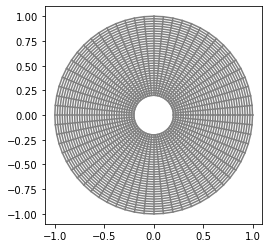

In [63]:
# plot mesh
xx = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
yy = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
zz = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')

mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], xx, 1, kind_map, params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], yy, 2, kind_map, params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], zz, 3, kind_map, params_map)


for i in range(len(el_b[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'grey')
    
for i in range(len(el_b[1]) - 1):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'grey')
    
plt.axis('square')

In [64]:
Fx   = lambda eta1, eta2, eta3 : (eta1*dR + R1)*np.cos(2*np.pi*eta2)
Fy   = lambda eta1, eta2, eta3 : (eta1*dR + R1)*np.sin(2*np.pi*eta2)
Fz   = lambda eta1, eta2, eta3 : Lz*eta3

# divergence-free 2-form
B2_1 = lambda eta1, eta2, eta3 :  (eta1*(1 - eta1)*np.sin(2*np.pi*eta1)*np.sin(6*np.pi*eta2))
B2_2 = lambda eta1, eta2, eta3 :  (((1 - 2*eta1)*np.sin(2*np.pi*eta1) + eta1*(1 - eta1)*np.cos(2*np.pi*eta1)*2*np.pi)*np.cos(6*np.pi*eta2))*1/(6*np.pi)
B2_3 = lambda eta1, eta2, eta3 :   0*eta1

# meshgrid for plots
ETA1, ETA2, ETA3 = np.meshgrid(etaplot[0], etaplot[1], etaplot[2], indexing='ij')

Text(0, 0.5, '$y$')

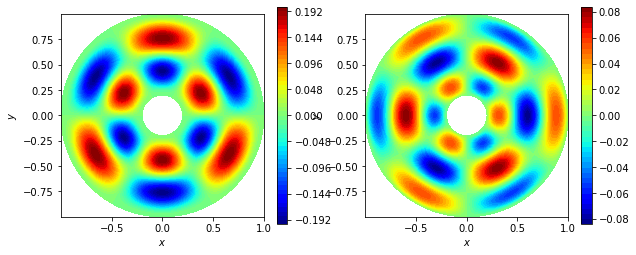

In [65]:
# plot components of 2-form on the physical domain
fig = plt.figure()
fig.set_figwidth(10)


plt.subplot(1, 2, 1)
plt.contourf(Fx(ETA1, ETA2, ETA3)[:, :, 0], Fy(ETA1, ETA2, ETA3)[:, :, 0], B2_1(ETA1, ETA2, ETA3)[:, :, 0], levels=50, cmap='jet')
plt.axis('square')

plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')


plt.subplot(1, 2, 2)
plt.contourf(Fx(ETA1, ETA2, ETA3)[:, :, 0], Fy(ETA1, ETA2, ETA3)[:, :, 0], B2_2(ETA1, ETA2, ETA3)[:, :, 0], levels=50, cmap='jet')
plt.axis('square')

    
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')

In [66]:
# perform projection
b2 = proj_loc.pi_2([B2_1, B2_2, B2_3])

In [67]:
error_L2 = l2.l2_error_V2(tensor_space, [B2_1, B2_2, B2_3], b2, 0, kind_map, params_map)

In [68]:
error_L2

0.00027456351927864663

In [69]:
bdiv = div.dot(np.concatenate((b2[0].flatten(), b2[1].flatten(), b2[2].flatten())))

In [70]:
bdiv_grev = np.empty((greville[0].size, greville[1].size, greville[2].size), dtype=float)

for i1 in range(greville[0].size):
    for i2 in range(greville[1].size):
        for i3 in range(greville[2].size):
            bdiv_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], bdiv)

In [71]:
np.abs(bdiv_grev).max()

2.989035234601811e-12

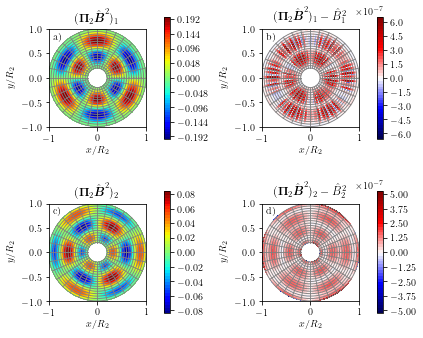

In [8]:
# plot discrete field and error
fig = plt.figure()
fig.set_figwidth(6.0)
fig.set_figheight(6.0)


plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# 1 - component
plt.subplot(2, 2, 1)
im = plt.contourf(Fx(ETA1, ETA2, ETA3)[:, :, 0], Fy(ETA1, ETA2, ETA3)[:, :, 0], tensor_space.evaluate_2form_3d(b2, etaplot, 1)[:, :, 0], levels=50, cmap='jet')
plt.axis('square')

for i in range(len(el_b[0])):
    if i%8 == 0:
        plt.plot(xx[i, :, 0], yy[i, :, 0], 'grey', linewidth=0.9)
    
for i in range(len(el_b[1]) - 1):
    if i%8 == 0:
        plt.plot(xx[:, i, 0], yy[:, i, 0], 'grey', linewidth=0.9)
    
plt.colorbar(im, fraction=0.05, pad=0.15)
plt.xlabel('$x/R_2$')
plt.ylabel('$y/R_2$')
plt.xlim((-1., 1.))
plt.ylim((-1., 1.))
plt.title(r'$(\boldsymbol{\Pi}_2\hat{\boldsymbol{B}}^2)_1$')
plt.text(-0.92, 0.78, 'a)')



# error
plt.subplot(2, 2, 2)
im = plt.contourf(Fx(ETA1, ETA2, ETA3)[:, :, 0], Fy(ETA1, ETA2, ETA3)[:, :, 0], tensor_space.evaluate_2form_3d(b2, etaplot, 1)[:, :, 0] - B2_1(ETA1, ETA2, ETA3)[:, :, 0], levels=50, cmap='seismic')
plt.axis('square')

for i in range(len(el_b[0])):
    if i%8 == 0:
        plt.plot(xx[i, :, 0], yy[i, :, 0], 'grey', linewidth=0.9)
    
for i in range(len(el_b[1]) - 1):
    if i%8 == 0:
        plt.plot(xx[:, i, 0], yy[:, i, 0], 'grey', linewidth=0.9)
    
plt.colorbar(im, fraction=0.05, pad=0.15)
plt.xlabel('$x/R_2$')
plt.ylabel('$y/R_2$')
plt.xlim((-1., 1.))
plt.ylim((-1., 1.))
plt.title(r'$(\boldsymbol{\Pi}_2\hat{\boldsymbol{B}}^2)_1-\hat{B}^2_1$')
plt.text(-0.92, 0.78, 'b)')



# 2 - component
plt.subplot(2, 2, 3)
im = plt.contourf(Fx(ETA1, ETA2, ETA3)[:, :, 0], Fy(ETA1, ETA2, ETA3)[:, :, 0], tensor_space.evaluate_2form_3d(b2, etaplot, 2)[:, :, 0], levels=50, cmap='jet')
plt.axis('square')

for i in range(len(el_b[0])):
    if i%8 == 0:
        plt.plot(xx[i, :, 0], yy[i, :, 0], 'grey', linewidth=0.9)
    
for i in range(len(el_b[1]) - 1):
    if i%8 == 0:
        plt.plot(xx[:, i, 0], yy[:, i, 0], 'grey', linewidth=0.9)
    
plt.colorbar(im, fraction=0.05, pad=0.15)
plt.xlabel('$x/R_2$')
plt.ylabel('$y/R_2$')
plt.xlim((-1., 1.))
plt.ylim((-1., 1.))
plt.title(r'$(\boldsymbol{\Pi}_2\hat{\boldsymbol{B}}^2)_2$')
plt.text(-0.92, 0.78, 'c)')

# error
plt.subplot(2, 2, 4)
im = plt.contourf(Fx(ETA1, ETA2, ETA3)[:, :, 0], Fy(ETA1, ETA2, ETA3)[:, :, 0], tensor_space.evaluate_2form_3d(b2, etaplot, 2)[:, :, 0] - B2_2(ETA1, ETA2, ETA3)[:, :, 0], levels=50, cmap='seismic')
plt.axis('square')

for i in range(len(el_b[0])):
    if i%8 == 0:
        plt.plot(xx[i, :, 0], yy[i, :, 0], 'grey', linewidth=0.9)
    
for i in range(len(el_b[1]) - 1):
    if i%8 == 0:
        plt.plot(xx[:, i, 0], yy[:, i, 0], 'grey', linewidth=0.9)
    
plt.colorbar(im,fraction=0.05, pad=0.15)
plt.xlabel('$x/R_2$')
plt.ylabel('$y/R_2$')
plt.xlim((-1., 1.))
plt.ylim((-1., 1.))
plt.title(r'$(\boldsymbol{\Pi}_2\hat{\boldsymbol{B}}^2)_2-\hat{B}^2_2$')
plt.text(-0.92, 0.78, 'd)')

plt.subplots_adjust(hspace=0.15, wspace=0.75)
plt.savefig('papers/02_FEEC_MHD/draft_June2020/projector_pi2.pdf', bbox_inches = 'tight')

# Plot meshes

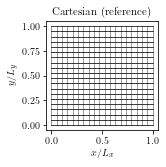

In [7]:
kind_map   = 1
params_map = [1., 1., 1.]

etaplot    = np.linspace(0., 1., 20), np.linspace(0., 1., 20), np.array([0.5])


plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')


fig = plt.figure()
fig.set_figwidth(2.0)
fig.set_figheight(2.0)

# plot mesh
xx = np.empty((etaplot[0].size, etaplot[1].size, etaplot[2].size), dtype=float, order='F')
yy = np.empty((etaplot[0].size, etaplot[1].size, etaplot[2].size), dtype=float, order='F')
zz = np.empty((etaplot[0].size, etaplot[1].size, etaplot[2].size), dtype=float, order='F')

mapping.kernel_eva([etaplot[0].size, etaplot[1].size, etaplot[2].size], etaplot[0], etaplot[1], etaplot[2], xx, 1, kind_map, params_map)
mapping.kernel_eva([etaplot[0].size, etaplot[1].size, etaplot[2].size], etaplot[0], etaplot[1], etaplot[2], yy, 2, kind_map, params_map)
mapping.kernel_eva([etaplot[0].size, etaplot[1].size, etaplot[2].size], etaplot[0], etaplot[1], etaplot[2], zz, 3, kind_map, params_map)


for i in range(len(etaplot[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'grey', linewidth=0.75)
    
for i in range(len(etaplot[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'black', linewidth=0.75)
    
plt.xlabel('$x/L_x$')
plt.ylabel('$y/L_y$')
plt.title('Cartesian (reference)', fontsize=11)

plt.savefig('papers/02_FEEC_MHD/draft_June2020/Cartesian_mesh.pdf', bbox_inches = 'tight')

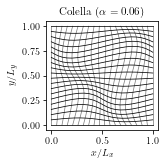

In [8]:
kind_map   = 3
params_map = [1., 1., 0.06, 1.]

etaplot    = np.linspace(0., 1., 20), np.linspace(0., 1., 20), np.array([0.5])


plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')


fig = plt.figure()
fig.set_figwidth(2.0)
fig.set_figheight(2.0)

# plot mesh
xx = np.empty((etaplot[0].size, etaplot[1].size, etaplot[2].size), dtype=float, order='F')
yy = np.empty((etaplot[0].size, etaplot[1].size, etaplot[2].size), dtype=float, order='F')
zz = np.empty((etaplot[0].size, etaplot[1].size, etaplot[2].size), dtype=float, order='F')

mapping.kernel_eva([etaplot[0].size, etaplot[1].size, etaplot[2].size], etaplot[0], etaplot[1], etaplot[2], xx, 1, kind_map, params_map)
mapping.kernel_eva([etaplot[0].size, etaplot[1].size, etaplot[2].size], etaplot[0], etaplot[1], etaplot[2], yy, 2, kind_map, params_map)
mapping.kernel_eva([etaplot[0].size, etaplot[1].size, etaplot[2].size], etaplot[0], etaplot[1], etaplot[2], zz, 3, kind_map, params_map)


for i in range(len(etaplot[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'grey', linewidth=0.75)
    
for i in range(len(etaplot[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'black', linewidth=0.75)
    
plt.xlabel('$x/L_x$')
plt.ylabel('$y/L_y$')
plt.title(r'Colella ($\alpha=0.06$)', fontsize=11)

plt.savefig('papers/02_FEEC_MHD/draft_June2020/Colella_mesh.pdf', bbox_inches = 'tight')

# Numerical results: Pure MHD

## Time step scan with white noise

In [2]:
# import parameters and output data (dt = 2)
import simulations.simulation_03062020_9.equilibrium_PIC       as eq_PIC
import simulations.simulation_03062020_9.equilibrium_MHD       as eq_MHD
import simulations.simulation_03062020_9.parameters_03062020_9 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_9/results_simulation_03062020_9.hdf5', 'r')

In [11]:
# import parameters and output data (dt = 4)
import simulations.simulation_03062020_10.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_10.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_10.parameters_03062020_10 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_10/results_simulation_03062020_10.hdf5', 'r')

In [2]:
# import parameters and output data (dt = 16)
import simulations.simulation_03062020_11.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_11.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_11.parameters_03062020_11 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_11/results_simulation_03062020_11.hdf5', 'r')

In [24]:
# import parameters and output data (dt = 32)
import simulations.simulation_03062020_12.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_12.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_12.parameters_03062020_12 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_12/results_simulation_03062020_12.hdf5', 'r')

In [25]:
# load data
pr   = file['pressure'][:]

b1   = file['magnetic_field/1_component'][:]
b2   = file['magnetic_field/2_component'][:]
b3   = file['magnetic_field/3_component'][:]

u3   = file['velocity_field/3_component'][:]

ma   = file['bulk_mass'][:]

en   = file['energies/bulk_kinetic'][:] + file['energies/magnetic'][:] + file['energies/bulk_internal'][:]

t    = file['time'][:]

Lx   = params.params_map[0]
Ly   = params.params_map[1]
Lz   = params.params_map[3]

Tend = params.Tend
dt   = params.dt

Nt   = int(Tend/dt)

Nel  = params.Nel
bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map     = params.kind_map
params_map   = params.params_map

# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]

In [26]:
# evaluate forms at element boundaries in xy-plane and map to physical domain
p_phys = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1), dtype=float)
Uz     = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1), dtype=float)


for tn in range(Nt + 1):
    
    if tn%100 == 0:
        print(tn)
    
    for i1 in range(el_b[0].size):
        for i2 in range(el_b[1].size):
    
            p_phys[tn, i1, i2] = tensor_space.evaluate_NNN(el_b[0][i1], el_b[1][i2], el_b[2][1], pr[tn])
            Uz[tn, i1, i2]     = mapping.df_inv(el_b[0][i1], el_b[1][i2], el_b[2][1], kind_map, params_map, 33)*tensor_space.evaluate_NND(el_b[0][i1], el_b[1][i2], el_b[2][1], u3[tn])

0
100


In [27]:
# determine L-infinity norm of div(B) (in physical space)
er_div     = np.zeros(Nt + 1, dtype=float)
b_div_grev = np.empty((greville[0].size, greville[1].size, greville[2].size), dtype=float)

for tn in range(Nt + 1):
    
    if tn%100 == 0:
        print(tn)
    
    # compute coefficients in V3
    b_div = div.dot(np.concatenate((b1[tn].flatten(), b2[tn].flatten(), b3[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
    
    er_div[tn] = np.abs(b_div_grev).max()

0
100


In [28]:
# perform 3d fft (time + x + y)
w     = (2*np.pi*(np.linspace(0,     Nt,     Nt + 1) -     Nt/2)/Tend)
kx    = (2*np.pi*(np.linspace(0, Nel[0], Nel[0] + 1) - Nel[0]/2)/Lx)
ky    = (2*np.pi*(np.linspace(0, Nel[1], Nel[1] + 1) - Nel[1]/2)/Ly)

W, KX, KY = np.meshgrid(w, kx, ky, indexing='ij')

pr_power_spectrum = np.fft.fftshift(np.abs(np.fft.fftn(p_phys)))
Uz_power_spectrum = np.fft.fftshift(np.abs(np.fft.fftn(Uz)))

# phase velocities of MHD waves
vFast  = disp.omegaM(1., +1, [1., 1., 0.], 1., 1., 5/3)
vSlow  = disp.omegaM(1., -1, [1., 1., 0.], 1., 1., 5/3)
vShear = disp.omegaS(1.,     [1., 1., 0.], 1.)

In [8]:
pr_power_spectrum_all = []
Uz_power_spectrum_all = []

W_all     = []
KX_all    = []
KY_all    = []

mass      = []
error_div = []
time      = []
energy    = []

In [30]:
pr_power_spectrum_all.append(pr_power_spectrum)
Uz_power_spectrum_all.append(Uz_power_spectrum)

W_all.append(W)
KX_all.append(KX)
KY_all.append(KY)

mass.append(ma)
error_div.append(er_div)
time.append(t)
energy.append(en)

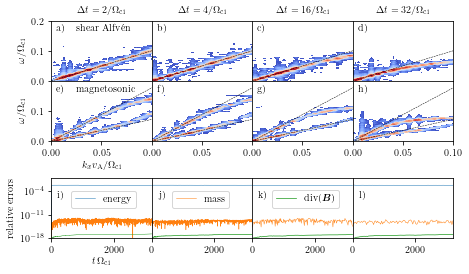

In [35]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(7.2)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]



ax1  = plt.subplot(341)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[0][:, :, 40], W_all[0][:, :, 40], Uz_power_spectrum_all[0][:, :, 40]**2/(Uz_power_spectrum_all[0][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title('$\Delta t=2/\Omega_\mathrm{ci}$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'a)')
plt.text(0.025, 0.165, 'shear Alfvén')
ax1.set_xticks([], [])


ax2  = plt.subplot(342)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[1][:, :, 40], W_all[1][:, :, 40], Uz_power_spectrum_all[1][:, :, 40]**2/(Uz_power_spectrum_all[1][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title('$\Delta t=4/\Omega_\mathrm{ci}$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'b)')
ax2.set_xticks([], [])
ax2.set_yticks([], [])


ax3  = plt.subplot(343)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[2][:, :, 40], W_all[2][:, :, 40], Uz_power_spectrum_all[2][:, :, 40]**2/(Uz_power_spectrum_all[2][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title('$\Delta t=16/\Omega_\mathrm{ci}$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'c)')
ax3.set_xticks([], [])
ax3.set_yticks([], [])



ax4  = plt.subplot(344)
lvls = np.logspace(-8, -5, 27)
cont = plt.contourf(KX_all[3][:, :, 40], W_all[3][:, :, 40], Uz_power_spectrum_all[3][:, :, 40]**2/(Uz_power_spectrum_all[3][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title('$\Delta t=32/\Omega_\mathrm{ci}$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'd)')
ax4.set_xticks([], [])
ax4.set_yticks([], [])

#fig.colorbar(cont, ax=[ax1, ax2, ax3], anchor=(1.5, 1.5), ticks=[1e-8, 1e-7, 1e-6, 1e-5])



ax5  = plt.subplot(345)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[0][:, :, 40], W_all[0][:, :, 40], pr_power_spectrum_all[0][:, :, 40]**2/(pr_power_spectrum_all[0][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=2\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'e)')
plt.text(0.025, 0.165, 'magnetosonic')
ax5.set_xticks([0.00, 0.05])
ax5.set_yticks([0.0, 0.1])



ax6  = plt.subplot(346)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[1][:, :, 40], W_all[1][:, :, 40], pr_power_spectrum_all[1][:, :, 40]**2/(pr_power_spectrum_all[1][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=16\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'f)')
ax6.set_xticks([0.00, 0.05])
ax6.set_yticks([], [])



ax7  = plt.subplot(347)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[2][:, :, 40], W_all[2][:, :, 40], pr_power_spectrum_all[2][:, :, 40]**2/(pr_power_spectrum_all[2][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'g)')
ax7.set_yticks([], [])
ax7.set_xticks([0.00, 0.05])



ax8  = plt.subplot(348)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[3][:, :, 40], W_all[3][:, :, 40], pr_power_spectrum_all[3][:, :, 40]**2/(pr_power_spectrum_all[3][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'h)')
ax8.set_yticks([], [])


#fig.colorbar(test2, ax=[ax4, ax5, ax6], anchor=(1.5, 1.0), ticks=[1e-8, 1e-7, 1e-6])
#plt.subplots_adjust(hspace=0.5, wspace=0)


ax9 = plt.subplot(349)
plt.semilogy(time[0], np.abs(energy[0] - energy[0][0])/energy[0][0], label='energy', linewidth=0.5)
plt.semilogy(time[0], np.abs(mass[0] - mass[0][0])/mass[0][0], linewidth=0.5)
plt.semilogy(time[0], error_div[0], linewidth=0.5)
plt.xlabel(r'$t\,\Omega_\text{ci}$')
plt.ylabel('relative errors')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=2\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.1, 0.5, 0., 0.))
plt.legend(loc=(0.2, 0.5))
plt.text(200., 1e-6, 'i)')


ax10 = plt.subplot(3, 4, 10)
plt.semilogy(time[1], np.abs(energy[1] - energy[1][0])/energy[1][0], linewidth=0.5)
plt.semilogy(time[1], np.abs(mass[1] - mass[1][0])/mass[1][0], label='mass', linewidth=0.5)
plt.semilogy(time[1], error_div[1], linewidth=0.75)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=16\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.1, 0.5, 0., 0.))
plt.legend(loc=(0.2, 0.5))
plt.text(200., 1e-6, 'j)')
ax10.set_yticks([], [])


ax11 = plt.subplot(3, 4, 11)
plt.semilogy(time[2][1:], np.abs(energy[2][1:] - energy[2][0])/energy[2][0], linewidth=0.5)
plt.semilogy(time[2][1:], np.abs(mass[2][1:] - mass[2][0])/mass[2][0], linewidth=0.5)
plt.semilogy(time[2], error_div[2], label=r'$\mathrm{div}(\boldsymbol{B})$', linewidth=0.75)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.05, 0.5, 0., 0.))
plt.legend(loc=(0.2, 0.5))
plt.text(200., 1e-6, 'k)')
ax11.set_yticks([], [])


ax12 = plt.subplot(3, 4, 12)
plt.semilogy(time[3][1:], np.abs(energy[3][1:] - energy[3][0])/energy[3][0], linewidth=0.5)
plt.semilogy(time[3][1:], np.abs(mass[3][1:] - mass[3][0])/mass[3][0], linewidth=0.5)
plt.semilogy(time[3], error_div[3], label=r'$\mathrm{div}(\boldsymbol{B})$', linewidth=0.75)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.05, 0.5, 0., 0.))
#plt.legend(loc='center')
plt.text(200., 1e-6, 'l)')
ax12.set_yticks([], [])



plt.subplots_adjust(wspace=0, hspace=0.3)

bbox = ax5.get_position()
ax5.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax6.get_position()
ax6.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax7.get_position()
ax7.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax8.get_position()
ax8.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

plt.savefig('paper_draft_07_2020/pure_MHD_timestep.pdf', bbox_inches = 'tight')

## Spline degree scan

In [2]:
# import parameters and output data (p = 2, dt = 2)
import simulations.simulation_03062020_16.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_16.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_16.parameters_03062020_16 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_16/results_simulation_03062020_16.hdf5', 'r')

In [9]:
# import parameters and output data (p = 3, dt = 2)
import simulations.simulation_03062020_9.equilibrium_PIC       as eq_PIC
import simulations.simulation_03062020_9.equilibrium_MHD       as eq_MHD
import simulations.simulation_03062020_9.parameters_03062020_9 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_9/results_simulation_03062020_9.hdf5', 'r')

In [15]:
# import parameters and output data (p = 4, dt = 2)
import simulations.simulation_03062020_17.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_17.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_17.parameters_03062020_17 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_17/results_simulation_03062020_17.hdf5', 'r')

In [16]:
# load data
pr   = file['pressure'][:]

b1   = file['magnetic_field/1_component'][:]
b2   = file['magnetic_field/2_component'][:]
b3   = file['magnetic_field/3_component'][:]

u3   = file['velocity_field/3_component'][:]

ma   = file['bulk_mass'][:]

en   = file['energies/bulk_kinetic'][:] + file['energies/magnetic'][:] + file['energies/bulk_internal'][:]

t    = file['time'][:]

Lx   = params.params_map[0]
Ly   = params.params_map[1]
Lz   = params.params_map[3]

Tend = params.Tend
dt   = params.dt

Nt   = int(Tend/dt)

Nel  = params.Nel
bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map     = params.kind_map
params_map   = params.params_map

# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# grid points on physical domain for fft
pts = [el_b*L for el_b, L in zip(el_b, [Lx, Ly, Lz])]

PTSX, PTSY, PTSZ = np.meshgrid(pts[0], pts[1], pts[2], indexing='ij')


# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]

In [17]:
# evaluate mappings at element boundaries
n_elb  = [el_b[0].size, el_b[1].size, el_b[2].size]
DF     = [np.empty((len(el_b[0]), len(el_b[1]), len(el_b[2])), dtype=float, order='F') for i in range(9)]
DF_inv = [np.empty((len(el_b[0]), len(el_b[1]), len(el_b[2])), dtype=float, order='F') for i in range(9)]
det_DF =  np.empty((len(el_b[0]), len(el_b[1]), len(el_b[2])), dtype=float, order='F')

components_DF     = [11, 12, 13, 14, 15, 16, 17, 18, 19]
components_DF_inv = [21, 22, 23, 24, 25, 26, 27, 28, 29]

for i in range(3):
    for j in range(3):
        mapping.kernel_eva(n_elb, el_b[0], el_b[1], el_b[2], DF[3*i + j], components_DF[3*i + j], kind_map, params_map)
        mapping.kernel_eva(n_elb, el_b[0], el_b[1], el_b[2], DF_inv[3*i + j], components_DF_inv[3*i + j], kind_map, params_map)
        
mapping.kernel_eva(n_elb, el_b[0], el_b[1], el_b[2], det_DF, 4, kind_map, params_map)


# evaluate forms at element boundaries in xy-plane and map to physical domain
p_phys = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1))

Bx     = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1))
By     = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1))
Bz     = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1))

Uz     = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1))


for tn in range(Nt + 1):
    p_phys[tn] = tensor_space.evaluate_0form_3d(pr[tn], el_b)[:, :, 1]
    
    #temp1      = tensor_space.evaluate_2form_3d([b1[tn], b2[tn], b3[tn]], el_b, 1)[:, :, 1]
    #temp2      = tensor_space.evaluate_2form_3d([b1[tn], b2[tn], b3[tn]], el_b, 2)[:, :, 1]
    #temp3      = tensor_space.evaluate_2form_3d([b1[tn], b2[tn], b3[tn]], el_b, 3)[:, :, 1]
    
    temp4      = tensor_space.evaluate_1form_3d([np.zeros((Nel[0], Nel[1], Nel[2])), np.zeros((Nel[0], Nel[1], Nel[2])), u3[tn]], el_b, 3)[:, :, 1]
    
    #Bx[tn]     = (DF[0][:, :, 1]*temp1 + DF[1][:, :, 1]*temp2 + DF[2][:, :, 1]*temp3)/det_DF[:, :, 1]
    #By[tn]     = (DF[3][:, :, 1]*temp1 + DF[4][:, :, 1]*temp2 + DF[5][:, :, 1]*temp3)/det_DF[:, :, 1]
    #Bz[tn]     = (DF[6][:, :, 1]*temp1 + DF[7][:, :, 1]*temp2 + DF[8][:, :, 1]*temp3)/det_DF[:, :, 1]
    
    Uz[tn]     =  DF_inv[8][:, :, 1]*temp4

In [18]:
# determine L-infinity norm of div(B)
er_div = np.zeros(Nt + 1)

for tn in range(Nt + 1):
    b_div = div.dot(np.concatenate((b1[tn].flatten(), b2[tn].flatten(), b3[tn].flatten())))
    
    er_div[tn] = (np.abs(tensor_space.evaluate_3form_3d(b_div, greville))).max()/det_DF.max()

In [19]:
# perform 3d fft (time + x + y)
w     = (2*np.pi*(np.linspace(0,     Nt,     Nt + 1) -     Nt/2)/Tend)
kx    = (2*np.pi*(np.linspace(0, Nel[0], Nel[0] + 1) - Nel[0]/2)/Lx)
ky    = (2*np.pi*(np.linspace(0, Nel[1], Nel[1] + 1) - Nel[1]/2)/Ly)

W, KX, KY = np.meshgrid(w, kx, ky, indexing='ij')

pr_power_spectrum = np.fft.fftshift(np.abs(np.fft.fftn(p_phys)))
Uz_power_spectrum = np.fft.fftshift(np.abs(np.fft.fftn(Uz)))

# phase velocities of MHD waves
vFast  = disp.omegaM(1., +1, [1., 1., 0.], 1., 1., 5/3)
vSlow  = disp.omegaM(1., -1, [1., 1., 0.], 1., 1., 5/3)
vShear = disp.omegaS(1.,     [1., 1., 0.], 1.)

In [7]:
pr_power_spectrum_all = []
Uz_power_spectrum_all = []

W_all     = []
KX_all    = []
KY_all    = []

mass      = []
error_div = []
time      = []
energy    = []

In [20]:
pr_power_spectrum_all.append(pr_power_spectrum)
Uz_power_spectrum_all.append(Uz_power_spectrum)

W_all.append(W)
KX_all.append(KX)
KY_all.append(KY)

mass.append(ma)
error_div.append(er_div)
time.append(t)
energy.append(en)

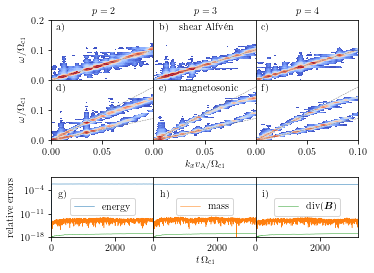

In [23]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5.5)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]



ax1 = plt.subplot(331)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[0][:, :, 40], W_all[0][:, :, 40], Uz_power_spectrum_all[0][:, :, 40]**2/(Uz_power_spectrum_all[0][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title('$p=2$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'a)')
ax1.set_xticks([], [])



ax2 = plt.subplot(332)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[1][:, :, 40], W_all[1][:, :, 40], Uz_power_spectrum_all[1][:, :, 40]**2/(Uz_power_spectrum_all[1][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title('$p=3$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'b)')
plt.text(0.025, 0.165, 'shear Alfvén')
ax2.set_xticks([], [])
ax2.set_yticks([], [])



ax3 = plt.subplot(333)
lvls = np.logspace(-8, -5, 27)
test1=plt.contourf(KX_all[2][:, :, 40], W_all[2][:, :, 40], Uz_power_spectrum_all[2][:, :, 40]**2/(Uz_power_spectrum_all[2][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title('$p=4$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'c)')
ax3.set_xticks([], [])
ax3.set_yticks([], [])



#fig.colorbar(test1, ax=[ax1, ax2, ax3], anchor=(1.5, 1.5), ticks=[1e-8, 1e-7, 1e-6, 1e-5])



ax4 = plt.subplot(334)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[0][:, :, 40], W_all[0][:, :, 40], pr_power_spectrum_all[0][:, :, 40]**2/(pr_power_spectrum_all[0][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=2\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'd)')
plt.xticks([0.00, 0.05], ('0.00', '0.05'))
plt.yticks([0.0, 0.1], ('0.0', '0.1'))



ax5 = plt.subplot(335)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[1][:, :, 40], W_all[1][:, :, 40], pr_power_spectrum_all[1][:, :, 40]**2/(pr_power_spectrum_all[1][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=16\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'e)')
plt.text(0.025, 0.165, 'magnetosonic')
plt.xticks([0.00, 0.05], ('0.00', '0.05'))
ax5.set_yticks([], [])
plt.setp(ax5.get_yticklabels(), visible=False)




ax6 = plt.subplot(336)
lvls = np.logspace(-8, -5, 27)
test2=plt.contourf(KX_all[2][:, :, 40], W_all[2][:, :, 40], pr_power_spectrum_all[2][:, :, 40]**2/(pr_power_spectrum_all[2][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='grey')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'f)')
ax6.set_yticks([], [])


#fig.colorbar(test2, ax=[ax4, ax5, ax6], anchor=(1.5, 1.0), ticks=[1e-8, 1e-7, 1e-6])
#plt.subplots_adjust(hspace=0.5, wspace=0)


ax7 = plt.subplot(337)
plt.semilogy(time[0], np.abs(energy[0] - energy[0][0])/energy[0][0], label='energy', linewidth=0.5)
plt.semilogy(time[0], np.abs(mass[0] - mass[0][0])/mass[0][0], linewidth=0.5)
plt.semilogy(time[0], error_div[0], linewidth=0.5)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
plt.ylabel('relative errors')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=2\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.1, 0.5, 0., 0.))
plt.legend(loc='center')
plt.text(200., 1e-6, 'g)')


ax8 = plt.subplot(338)
plt.semilogy(time[1], np.abs(energy[1] - energy[1][0])/energy[1][0], linewidth=0.5)
plt.semilogy(time[1], np.abs(mass[1] - mass[1][0])/mass[1][0], label='mass', linewidth=0.5)
plt.semilogy(time[1], error_div[1], linewidth=0.5)
plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=16\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.1, 0.5, 0., 0.))
plt.legend(loc='center')
plt.setp(ax8.get_yticklabels(), visible=False)
plt.text(200., 1e-6, 'h)')
ax8.set_yticks([], [])


ax9 = plt.subplot(339)

plt.semilogy(time[2][1:], np.abs(energy[2][1:] - energy[2][0])/energy[2][0], linewidth=0.5)
plt.semilogy(time[2][1:], np.abs(mass[2][1:] - mass[2][0])/mass[2][0], linewidth=0.5)
plt.semilogy(time[2], error_div[2], label=r'$\mathrm{div}(\boldsymbol{B})$', linewidth=0.5)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.05, 0.5, 0., 0.))
plt.legend(loc='center')
plt.setp(ax9.get_yticklabels(), visible=False)
plt.text(200., 1e-6, 'i)')
ax9.set_yticks([], [])



plt.subplots_adjust(wspace=0, hspace=0.3)

bbox = ax4.get_position()
ax4.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax5.get_position()
ax5.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax6.get_position()
ax6.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

plt.savefig('papers/02_FEEC_MHD/draft_June2020/pure_MHD_degree.pdf', bbox_inches = 'tight')

## Nonuniformity scan with colella

In [10]:
# import parameters and output data (alpha = 0.02)
import simulations.simulation_03062020_13.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_13.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_13.parameters_03062020_13 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_13/results_simulation_03062020_13.hdf5', 'r')

In [17]:
# import parameters and output data (alpha = 0.04)
import simulations.simulation_03062020_14.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_14.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_14.parameters_03062020_14 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_14/results_simulation_03062020_14.hdf5', 'r')

In [24]:
# import parameters and output data (alpha = 0.06)
import simulations.simulation_03062020_15.equilibrium_PIC        as eq_PIC
import simulations.simulation_03062020_15.equilibrium_MHD        as eq_MHD
import simulations.simulation_03062020_15.parameters_03062020_15 as pa

params = pa.parameters()

file   = h5py.File('../../simulations/simulation_03062020_15/results_simulation_03062020_15.hdf5', 'r')

In [25]:
# load data
pr   = file['pressure'][:]

b1   = file['magnetic_field/1_component'][:]
b2   = file['magnetic_field/2_component'][:]
b3   = file['magnetic_field/3_component'][:]

u3   = file['velocity_field/3_component'][:]

ma   = file['bulk_mass'][:]

en   = file['energies/bulk_kinetic'][:] + file['energies/magnetic'][:] + file['energies/bulk_internal'][:]

t    = file['time'][:]

Lx   = params.params_map[0]
Ly   = params.params_map[1]
Lz   = params.params_map[3]

Tend = params.Tend
dt   = params.dt

Nt   = int(Tend/dt)

Nel  = params.Nel
bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map     = params.kind_map
params_map   = params.params_map

# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# grid points on physical domain for fft
pts = [el_b*L for el_b, L in zip(el_b, [Lx, Ly, Lz])]

# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]

In [26]:
# inverse mapping with Newton-method (get logical coordinates corresponding to uniform grid on physical domain)
tol = 1e-10

def F(eta1, eta2, eta3):
    
    x = mapping.f(eta1, eta2, eta3, kind_map, params_map, 1)
    y = mapping.f(eta1, eta2, eta3, kind_map, params_map, 2)
    z = mapping.f(eta1, eta2, eta3, kind_map, params_map, 3)
    
    return np.array([x, y, z]) - xx


DF_inv            = np.zeros((3, 3), dtype=float)
components_DF_inv = [[11, 12, 13], 
                     [21, 22, 23], 
                     [31, 32, 33]]


ETA1 = np.zeros((pts[0].size, pts[1].size, pts[2].size), dtype=float)
ETA2 = np.zeros((pts[0].size, pts[1].size, pts[2].size), dtype=float)
ETA3 = np.zeros((pts[0].size, pts[1].size, pts[2].size), dtype=float)


for i1 in range(pts[0].size):
    for i2 in range(pts[1].size):
        for i3 in range(pts[2].size):
            
            xx  = np.array([pts[0][i1], pts[1][i2], pts[2][i3]])
            eta = np.array([0.5, 0.5, 0.5])

            # Newton iterations
            while np.any(np.abs(F(eta[0], eta[1], eta[2])) > tol):

                # assemble inverse Jacobian
                for i in range(3):
                    for j in range(3):
                        DF_inv[i, j] = mapping.df_inv(eta[0], eta[1], eta[2], kind_map, params_map, components_DF_inv[i][j])

                eta = eta - DF_inv.dot(F(eta[0], eta[1], eta[2]))
                
            ETA1[i1, i2, i3] = eta[0]
            ETA2[i1, i2, i3] = eta[1]
            ETA3[i1, i2, i3] = eta[2]

In [28]:
# evaluate forms at element boundaries in xy-plane
p_phys = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1), dtype=float)
Uz     = np.zeros((Nt + 1, Nel[0] + 1, Nel[1] + 1), dtype=float)


for tn in range(Nt + 1):
    
    if tn%100 == 0:
        print(tn)
    
    for i1 in range(el_b[0].size):
        for i2 in range(el_b[1].size):
    
            p_phys[tn, i1, i2] = tensor_space.evaluate_NNN(ETA1[i1, i2, 1], ETA2[i1, i2, 1], ETA3[i1, i2, 1], pr[tn])
            Uz[tn, i1, i2]     = mapping.df_inv(ETA1[i1, i2, 1], ETA2[i1, i2, 1], ETA3[i1, i2, 1], kind_map, params_map, 33)*tensor_space.evaluate_NND(ETA1[i1, i2, 1], ETA2[i1, i2, 1], ETA3[i1, i2, 1], u3[tn])

0
100
200


In [29]:
# determine L-infinity norm of div(B) (in physical space)
er_div     = np.zeros(Nt + 1, dtype=float)
b_div_grev = np.empty((greville[0].size, greville[1].size, greville[2].size), dtype=float)

for tn in range(Nt + 1):
    
    if tn%100 == 0:
        print(tn)
    
    # compute coefficients in V3
    b_div = div.dot(np.concatenate((b1[tn].flatten(), b2[tn].flatten(), b3[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
    
    er_div[tn] = np.abs(b_div_grev).max()

0
100
200


In [30]:
# perform 3d fft (time + x + y)
w     = (2*np.pi*(np.linspace(0,     Nt,     Nt + 1) -     Nt/2)/Tend)
kx    = (2*np.pi*(np.linspace(0, Nel[0], Nel[0] + 1) - Nel[0]/2)/Lx)
ky    = (2*np.pi*(np.linspace(0, Nel[1], Nel[1] + 1) - Nel[1]/2)/Ly)

W, KX, KY = np.meshgrid(w, kx, ky, indexing='ij')

pr_power_spectrum = np.fft.fftshift(np.abs(np.fft.fftn(p_phys)))
Uz_power_spectrum = np.fft.fftshift(np.abs(np.fft.fftn(Uz)))

# phase velocities of MHD waves
vFast  = disp.omegaM(1., +1, [1., 1., 0.], 1., 1., 5/3)
vSlow  = disp.omegaM(1., -1, [1., 1., 0.], 1., 1., 5/3)
vShear = disp.omegaS(1.,     [1., 1., 0.], 1.)

In [8]:
pr_power_spectrum_all = []
Uz_power_spectrum_all = []

W_all     = []
KX_all    = []
KY_all    = []

mass      = []
error_div = []
time      = []
energy    = []

In [31]:
pr_power_spectrum_all.append(pr_power_spectrum)
Uz_power_spectrum_all.append(Uz_power_spectrum)

W_all.append(W)
KX_all.append(KX)
KY_all.append(KY)

mass.append(ma)
error_div.append(er_div)
time.append(t)
energy.append(en)

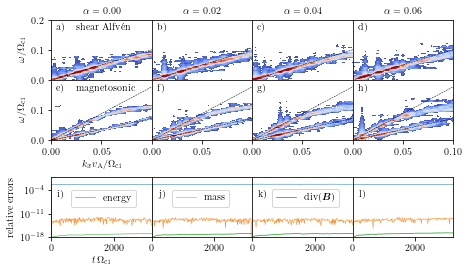

In [33]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(7.2)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]



ax1  = plt.subplot(341)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[0][:, :, 40], W_all[0][:, :, 40], Uz_power_spectrum_all[0][:, :, 40]**2/(Uz_power_spectrum_all[0][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title(r'$\alpha=0.00$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'a)')
plt.text(0.025, 0.165, 'shear Alfvén')
ax1.set_xticks([], [])


ax2  = plt.subplot(342)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[1][:, :, 40], W_all[1][:, :, 40], Uz_power_spectrum_all[1][:, :, 40]**2/(Uz_power_spectrum_all[1][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title(r'$\alpha=0.02$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'b)')
ax2.set_xticks([], [])
ax2.set_yticks([], [])


ax3  = plt.subplot(343)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[2][:, :, 40], W_all[2][:, :, 40], Uz_power_spectrum_all[2][:, :, 40]**2/(Uz_power_spectrum_all[2][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title(r'$\alpha=0.04$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'c)')
ax3.set_xticks([], [])
ax3.set_yticks([], [])



ax4  = plt.subplot(344)
lvls = np.logspace(-8, -5, 27)
cont = plt.contourf(KX_all[3][:, :, 40], W_all[3][:, :, 40], Uz_power_spectrum_all[3][:, :, 40]**2/(Uz_power_spectrum_all[3][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
plt.title(r'$\alpha=0.06$', fontsize=10)
plt.plot(np.linspace(0, 8., 50), vShear*np.linspace(0, 8., 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'd)')
ax4.set_xticks([], [])
ax4.set_yticks([], [])

#fig.colorbar(cont, ax=[ax1, ax2, ax3], anchor=(1.5, 1.5), ticks=[1e-8, 1e-7, 1e-6, 1e-5])



ax5  = plt.subplot(345)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[0][:, :, 40], W_all[0][:, :, 40], pr_power_spectrum_all[0][:, :, 40]**2/(pr_power_spectrum_all[0][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=2\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'e)')
plt.text(0.025, 0.165, 'magnetosonic')
ax5.set_xticks([0.00, 0.05])
ax5.set_yticks([0.0, 0.1])



ax6  = plt.subplot(346)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[1][:, :, 40], W_all[1][:, :, 40], pr_power_spectrum_all[1][:, :, 40]**2/(pr_power_spectrum_all[1][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=16\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'f)')
ax6.set_xticks([0.00, 0.05])
ax6.set_yticks([], [])



ax7  = plt.subplot(347)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[2][:, :, 40], W_all[2][:, :, 40], pr_power_spectrum_all[2][:, :, 40]**2/(pr_power_spectrum_all[2][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'g)')
ax7.set_yticks([], [])
ax7.set_xticks([0.00, 0.05])



ax8  = plt.subplot(348)
lvls = np.logspace(-8, -5, 27)
plt.contourf(KX_all[3][:, :, 40], W_all[3][:, :, 40], pr_power_spectrum_all[3][:, :, 40]**2/(pr_power_spectrum_all[3][:, :, 40]**2).max(), cmap = 'coolwarm', norm = LogNorm(), levels=lvls)
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
plt.plot(np.linspace(0, 10, 50), vFast*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.plot(np.linspace(0, 10, 50), vSlow*np.linspace(0, 10, 50), linestyle='dashed', linewidth=0.5, color='black')
plt.xlim((0., 0.1))
plt.ylim((0., 0.2))
#plt.colorbar(ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
#plt.xlabel('$k_x v_\mathrm{A}/\Omega_\mathrm{ci}$')
#plt.ylabel('$\omega/\Omega_\mathrm{ci}$')
plt.text(0.005, 0.165, 'h)')
ax8.set_yticks([], [])


#fig.colorbar(test2, ax=[ax4, ax5, ax6], anchor=(1.5, 1.0), ticks=[1e-8, 1e-7, 1e-6])
#plt.subplots_adjust(hspace=0.5, wspace=0)


ax9 = plt.subplot(349)
plt.semilogy(time[0], np.abs(energy[0] - energy[0][0])/energy[0][0], label='energy', linewidth=0.5)
plt.semilogy(time[0], np.abs(mass[0] - mass[0][0])/mass[0][0], linewidth=0.5)
plt.semilogy(time[0], error_div[0], linewidth=0.5)
plt.xlabel(r'$t\,\Omega_\text{ci}$')
plt.ylabel('relative errors')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=2\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.1, 0.5, 0., 0.))
plt.legend(loc=(0.2, 0.5))
plt.text(200., 1e-6, 'i)')


ax10 = plt.subplot(3, 4, 10)
plt.semilogy(time[1], np.abs(energy[1] - energy[1][0])/energy[1][0], linewidth=0.5)
plt.semilogy(time[1], np.abs(mass[1] - mass[1][0])/mass[1][0], label='mass', linewidth=0.5)
plt.semilogy(time[1], error_div[1], linewidth=0.75)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=16\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.1, 0.5, 0., 0.))
plt.legend(loc=(0.2, 0.5))
plt.text(200., 1e-6, 'j)')
ax10.set_yticks([], [])


ax11 = plt.subplot(3, 4, 11)
plt.semilogy(time[2][1:], np.abs(energy[2][1:] - energy[2][0])/energy[2][0], linewidth=0.5)
plt.semilogy(time[2][1:], np.abs(mass[2][1:] - mass[2][0])/mass[2][0], linewidth=0.5)
plt.semilogy(time[2], error_div[2], label=r'$\mathrm{div}(\boldsymbol{B})$', linewidth=0.75)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.05, 0.5, 0., 0.))
plt.legend(loc=(0.2, 0.5))
plt.text(200., 1e-6, 'k)')
ax11.set_yticks([], [])


ax12 = plt.subplot(3, 4, 12)
plt.semilogy(time[3][1:], np.abs(energy[3][1:] - energy[3][0])/energy[3][0], linewidth=0.5)
plt.semilogy(time[3][1:], np.abs(mass[3][1:] - mass[3][0])/mass[3][0], linewidth=0.5)
plt.semilogy(time[3], error_div[3], label=r'$\mathrm{div}(\boldsymbol{B})$', linewidth=0.75)
#plt.xlabel(r'$t\,\Omega_\text{ci}$')
#plt.ylabel('relative error')
plt.xlim((0., 3200.))
plt.ylim((1e-18, 1e0))
#plt.title('$\Delta t=32\,\Omega_\mathrm{ci}$')
#plt.legend(bbox_to_anchor=(0.05, 0.5, 0., 0.))
#plt.legend(loc='center')
plt.text(200., 1e-6, 'l)')
ax12.set_yticks([], [])



plt.subplots_adjust(wspace=0, hspace=0.3)

bbox = ax5.get_position()
ax5.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax6.get_position()
ax6.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax7.get_position()
ax7.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

bbox = ax8.get_position()
ax8.set_position([bbox.x0, bbox.y0 + 0.063, bbox.x1-bbox.x0, bbox.y1-bbox.y0])

plt.savefig('paper_draft_07_2020/pure_MHD_mapping.pdf', bbox_inches = 'tight')

# Numerical results: Wave-particle resonance

## Dispersion relation

In [80]:
import scipy.special as sp


nuh  = 0.05
vth  = 1.
Ah   = 1
Zh   = 1
AMHD = 1
v0   = 2.5
wch  = 1.
vA   = 1.

k    = np.linspace(0.26, 2., 100)

cases_v0 = 6
v0s      = np.array([0., 0.5, 1.0, 1.5, 2.0, 2.5])

w1 = np.zeros((len(v0s), len(k)), dtype=complex)
w2 = np.zeros((len(v0s), len(k)), dtype=complex)

w1[:, 0] = 0.01 + 0j
w2[:, 0] = 0.01 + 0j

for j in range(len(v0s)):

    for i in range(len(k)):

        if i == 0:
            w1[j, i] = disp.solveDispersionFullOrbit(k[i], +1, 1., 1., vth, v0s[j], nuh, Ah, Zh, AMHD, w1[j, i], 1e-6, max_it=100)[0]
            w2[j, i] = disp.solveDispersionFullOrbit(k[i], -1, 1., 1., vth, v0s[j], nuh, Ah, Zh, AMHD, w2[j, i], 1e-6, max_it=100)[0]


        else:
            w1[j, i] = disp.solveDispersionFullOrbit(k[i], +1, 1., 1., vth, v0s[j], nuh, Ah, Zh, AMHD, w1[j, i - 1], 1e-6, max_it=100)[0]
            w2[j, i] = disp.solveDispersionFullOrbit(k[i], -1, 1., 1., vth, v0s[j], nuh, Ah, Zh, AMHD, w2[j, i - 1], 1e-6, max_it=100)[0]

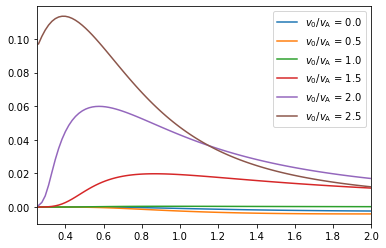

In [81]:
for i in range(len(v0s)): 
    plt.plot(k, np.imag(w1[i]), label='$v_0/v_\mathrm{A}$ = ' + str(v0s[i]))
    
    
plt.xlim((0.25, 2.))
plt.legend()

In [82]:
disp.solveDispersionFullOrbit(0.8, +1, 1., 1., vth, 2.5, 0.05, Ah, Zh, AMHD, 0.8 + 0j, 1e-10, max_it=100)[0]

(0.8012438541508197+0.06813331353478991j)

## Time step scan Cartesian mapping

In [3]:
# import parameters and output data
import simulations.simulation_16062020_1.parameters_16062020_1 as pa
import simulations.simulation_16062020_1.equilibrium_PIC       as eq_PIC
import simulations.simulation_16062020_1.equilibrium_MHD       as eq_MHD

params = pa.parameters()
file1  = h5py.File('../../simulations/simulation_16062020_1/results_simulation_16062020_1.hdf5', 'r')
file2  = h5py.File('../../simulations/simulation_16062020_2/results_simulation_16062020_2.hdf5', 'r')
file3  = h5py.File('../../simulations/simulation_16062020_3/results_simulation_16062020_3.hdf5', 'r')
file4  = h5py.File('../../simulations/simulation_16062020_4/results_simulation_16062020_4.hdf5', 'r')

In [4]:
from scipy import integrate

Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

Nel  = params.Nel
bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map     = params.kind_map
params_map   = params.params_map

# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]


# compute equilibrium energies
en_B0   = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0   = eq_PIC.eh_eq(params.kind_map, params.params_map)
en_p0   = 1/(5/3 - 1)*Lx*Ly*Lz

# load perturbed energies, mass and b-coefficients
tn1     = file1['time'][:]
en_U1   = file1['energies/bulk_kinetic'][:]
en_B1   = file1['energies/magnetic'][:]
en_H1   = file1['energies/energetic_deltaf'][:]
en_p1   = file1['energies/bulk_internal'][:]
en_tot1 = en_U1 + en_B1 + en_H1 + en_p1 + en_B0 + en_H0 + en_p0
#mass1   = file1['bulk_mass'][:]
b1_1    = file1['magnetic_field/1_component'][:]
b2_1    = file1['magnetic_field/2_component'][:]
b3_1    = file1['magnetic_field/3_component'][:]

tn2     = file2['time'][:]
en_U2   = file2['energies/bulk_kinetic'][:]
en_B2   = file2['energies/magnetic'][:]
en_H2   = file2['energies/energetic_deltaf'][:]
en_p2   = file2['energies/bulk_internal'][:]
en_tot2 = en_U2 + en_B2 + en_H2 + en_p2 + en_B0 + en_H0 + en_p0
#mass2   = file2['bulk_mass'][:]
b1_2    = file2['magnetic_field/1_component'][:]
b2_2    = file2['magnetic_field/2_component'][:]
b3_2    = file2['magnetic_field/3_component'][:]

tn3     = file3['time'][:]
en_U3   = file3['energies/bulk_kinetic'][:]
en_B3   = file3['energies/magnetic'][:]
en_H3   = file3['energies/energetic_deltaf'][:]
en_p3   = file3['energies/bulk_internal'][:]
en_tot3 = en_U3 + en_B3 + en_H3 + en_p3 + en_B0 + en_H0 + en_p0
#mass3   = file3['bulk_mass'][:]
b1_3    = file3['magnetic_field/1_component'][:]
b2_3    = file3['magnetic_field/2_component'][:]
b3_3    = file3['magnetic_field/3_component'][:]

tn4     = file4['time'][:]
en_U4   = file4['energies/bulk_kinetic'][:]
en_B4   = file4['energies/magnetic'][:]
en_H4   = file4['energies/energetic_deltaf'][:]
en_p4   = file4['energies/bulk_internal'][:]
en_tot4 = en_U4 + en_B4 + en_H4 + en_p4 + en_B0 + en_H0 + en_p0
#mass4   = file4['bulk_mass'][:]
b1_4    = file4['magnetic_field/1_component'][:]
b2_4    = file4['magnetic_field/2_component'][:]
b3_4    = file4['magnetic_field/3_component'][:]

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.8, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=0.8 + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.8

In [6]:
# determine L-infinity norm of div(B)
er_div1 = np.zeros(tn1.size, dtype=float)
er_div2 = np.zeros(tn2.size, dtype=float)
er_div3 = np.zeros(tn3.size, dtype=float)
er_div4 = np.zeros(tn4.size, dtype=float)

b_div_grev = np.empty((greville[0].size, greville[1].size, greville[2].size), dtype=float)

for tn in range(tn1.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_1[tn].flatten(), b2_1[tn].flatten(), b3_1[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
    
    er_div1[tn] = np.abs(b_div_grev).max()
print('1 done')   

    
for tn in range(tn2.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_2[tn].flatten(), b2_2[tn].flatten(), b3_2[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)

    er_div2[tn] = np.abs(b_div_grev).max()
print('2 done')  

for tn in range(tn3.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_3[tn].flatten(), b2_3[tn].flatten(), b3_3[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
    
    er_div3[tn] = np.abs(b_div_grev).max()
print('3 done')  
    
for tn in range(tn4.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_4[tn].flatten(), b2_4[tn].flatten(), b3_4[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
                
    er_div4[tn] = np.abs(b_div_grev).max()
print('4 done')  

1 done
2 done
3 done
4 done


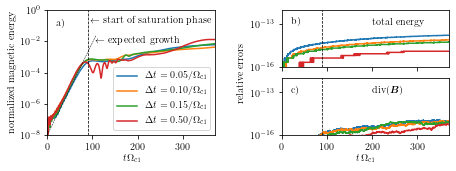

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex='col')

fig.set_figheight(2.3)
fig.set_figwidth(7.2)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

gs = axs[0, 0].get_gridspec()

# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0:, 0])

axbig.semilogy(tn1, en_B1/en_tot1[0], label='$\Delta t=0.05/\Omega_\mathrm{ci}$')
axbig.semilogy(tn2, en_B2/en_tot2[0], label='$\Delta t=0.10/\Omega_\mathrm{ci}$')
axbig.semilogy(tn3, en_B3/en_tot3[0], label='$\Delta t=0.15/\Omega_\mathrm{ci}$')
axbig.semilogy(tn4, en_B4/en_tot4[0], label='$\Delta t=0.50/\Omega_\mathrm{ci}$')
axbig.semilogy(tn1[0:2150], 1e-8*np.exp(2*tn1[0:2150]*wi), 'k--', linewidth=0.5)

axbig.set_ylim((1e-8, 1e0))
axbig.set_xlim((0., 370.))
axbig.set_xlabel('$t\Omega_\mathrm{ci}$')
axbig.set_ylabel('normalized magnetic energy')
axbig.legend()
axbig.plot(np.ones(10)*90, np.linspace(1e-9, 1e0, 10), 'k--', linewidth=0.75)
axbig.text(95, 1.5e-1, '$\leftarrow$ start of saturation phase')
axbig.text(105, 8e-3, '$\leftarrow$ expected growth')
axbig.text(20, 1e-1, 'a)')


axs[0, 1].semilogy(tn1, np.abs(en_tot1[0] - en_tot1)/en_tot1[0], color='#1f77b4')
axs[0, 1].semilogy(tn2, np.abs(en_tot2[0] - en_tot2)/en_tot2[0], color='#ff7f0e')
axs[0, 1].semilogy(tn3, np.abs(en_tot3[0] - en_tot3)/en_tot3[0], color='#2ca02c')
axs[0, 1].semilogy(tn4, np.abs(en_tot4[0] - en_tot4)/en_tot4[0], color='#d62728')
axs[0, 1].set_ylim((1e-16, 1e-12))
axs[0, 1].set_xlim((0., 370.))
axs[0, 1].text(20, 1e-13, 'b)')
axs[0, 1].plot(np.ones(10)*90, np.linspace(1e-16, 1e-12, 10), 'k--', linewidth=0.75)
axs[0, 1].text(200, 1e-13, 'total energy')


axs[1, 1].semilogy(tn1, er_div1, color='#1f77b4')
axs[1, 1].semilogy(tn2, er_div2, color='#ff7f0e')
axs[1, 1].semilogy(tn3, er_div3, color='#2ca02c')
axs[1, 1].semilogy(tn4, er_div4, color='#d62728')

axs[1, 1].set_xlabel(r'$t\,\Omega_\mathrm{ci}$')
axs[1, 1].set_ylim((1e-16, 1e-12))
axs[1, 1].text(20, 1e-13, 'c)')
axs[1, 1].plot(np.ones(10)*90, np.linspace(1e-16, 1e-12, 10), 'k--', linewidth=0.75)
axs[1, 1].text(200, 1e-13, r'$\mathrm{div}(\boldsymbol{B})$')

fig.text(0.5, 0.5, 'relative errors', ha='center', va='center', rotation='vertical')


plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.savefig('paper_draft_07_2020/wave_particle_timestep.pdf', bbox_inches = 'tight')

## Phase space plots

In [2]:
# import parameters and output data
import simulations.simulation_16062020_1.parameters_16062020_1 as pa
import simulations.simulation_16062020_1.equilibrium_PIC       as eq_PIC
import simulations.simulation_16062020_1.equilibrium_MHD       as eq_MHD

params = pa.parameters()
file1  = h5py.File('simulations/simulation_16062020_1/results_simulation_16062020_1.hdf5', 'r')

In [3]:
from scipy import integrate

Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

Nel  = params.Nel
bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map     = params.kind_map
params_map   = params.params_map

# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]


# compute equilibrium energies
en_B0   = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0   = eq_PIC.eh_eq(params.kind_map, params.params_map)
en_p0   = 1/(5/3 - 1)*Lx*Ly*Lz

# load perturbed energies, mass and b-coefficients
tn1     = file1['time'][:]
en_U1   = file1['energies/bulk_kinetic'][:]
en_B1   = file1['energies/magnetic'][:]
en_H1   = file1['energies/energetic_deltaf'][:]
en_p1   = file1['energies/bulk_internal'][:]
en_tot1 = en_U1 + en_B1 + en_H1 + en_p1 + en_B0 + en_H0 + en_p0
#mass1   = file1['bulk_mass'][:]
b1_1    = file1['magnetic_field/1_component'][:]
b2_1    = file1['magnetic_field/2_component'][:]
b3_1    = file1['magnetic_field/3_component'][:]


# distribution function
fh_xi1_vx = file1['distribution_function/xi1_vx'][:]

# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.8, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=0.8 + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.8

In [4]:
# plot evolution of distribution function in x - vx space 
n_bins    = [fh_xi1_vx.shape[1], fh_xi1_vx.shape[2]]
bin_edges = [np.linspace(0., 1., n_bins[0] + 1), np.linspace(0., 5., n_bins[1] + 1)]
dbin      = [bin_edges[0][1] - bin_edges[0][0], bin_edges[1][1] - bin_edges[1][0]]
bins      = [bin_edges[0][:-1] + dbin[0]/2, bin_edges[1][:-1] + dbin[1]/2]

Text(0, 0.5, 'vx')

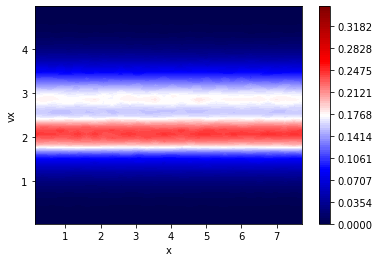

In [5]:
X, VX = np.meshgrid(bins[0]*Lx, bins[1], indexing='ij')
f_eq  = lambda x, vx : 0.05*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
Nt    = fh_xi1_vx.shape[0] - 1

cont = plt.contourf(X, VX, fh_xi1_vx[2000]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
plt.colorbar()

plt.xlabel('x')
plt.ylabel('vx')
#plt.title('t=231.75')

Text(0, 0.5, 'vx')

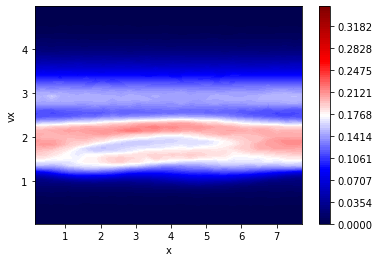

In [6]:
X, VX = np.meshgrid(bins[0]*Lx, bins[1], indexing='ij')
f_eq  = lambda x, vx : 0.05*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
Nt    = fh_xi1_vx.shape[0] - 1

cont = plt.contourf(X, VX, fh_xi1_vx[4650]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
plt.colorbar()

plt.xlabel('x')
plt.ylabel('vx')
#plt.title('t=231.75')

In [8]:
bins[0]

array([0.015625, 0.046875, 0.078125, 0.109375, 0.140625, 0.171875,
       0.203125, 0.234375, 0.265625, 0.296875, 0.328125, 0.359375,
       0.390625, 0.421875, 0.453125, 0.484375, 0.515625, 0.546875,
       0.578125, 0.609375, 0.640625, 0.671875, 0.703125, 0.734375,
       0.765625, 0.796875, 0.828125, 0.859375, 0.890625, 0.921875,
       0.953125, 0.984375])

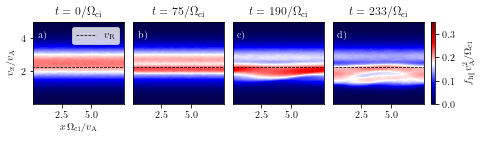

In [19]:
X, VX = np.meshgrid(bins[0]*Lx, bins[1], indexing='ij')
f_eq  = lambda x, vx : 0.05*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
Nt    = fh_xi1_vx.shape[0] - 1


fig = plt.figure()
fig.set_figheight(1.5)
fig.set_figwidth(7)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]



ax1 = plt.subplot(141)
cont = plt.contourf(X, VX, fh_xi1_vx[0]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
#plt.colorbar(ticks=[0., 0.1, 0.2, 0.3])
plt.xlabel(r'$x\,\Omega_\mathrm{ci}/v_\mathrm{A}$')
plt.ylabel(r'$v_x/v_\mathrm{A}$')
plt.title(r'$t=0/\Omega_\mathrm{ci}$')
plt.xlim(dbin[0]/2*Lx, Lx - dbin[0]/2*Lx)
ax1.set_xticks([2.5, 5.0])
plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.75, label='$v_\mathrm{R}$')
plt.text(0.5, 4.0, 'a)', color='w')
plt.legend()


ax2 = plt.subplot(142)
cont = plt.contourf(X, VX, fh_xi1_vx[1500]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
#plt.colorbar(ticks=[0., 0.1, 0.2, 0.3])
#plt.xlabel(r'$x\,\Omega_\mathrm{ci}/v_\mathrm{A}$')
#plt.ylabel(r'$vx/v_\mathrm{A}$')
plt.title(r'$t=75/\Omega_\mathrm{ci}$')
plt.xlim(dbin[0]/2*Lx, Lx - dbin[0]/2*Lx)
ax2.set_yticks([], [])
ax2.set_xticks([2.5, 5.0])
plt.text(0.5, 4.0, 'b)', color='w')
plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.75)


ax3 = plt.subplot(143)
cont = plt.contourf(X, VX, fh_xi1_vx[3800]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
#plt.colorbar(ticks=[0., 0.1, 0.2, 0.3])
#plt.xlabel(r'$x\,\Omega_\mathrm{ci}/v_\mathrm{A}$')
#plt.ylabel(r'$vx/v_\mathrm{A}$')
plt.title(r'$t=190/\Omega_\mathrm{ci}$')
plt.xlim(dbin[0]/2*Lx, Lx - dbin[0]/2*Lx)
ax3.set_yticks([], [])
ax3.set_xticks([2.5, 5.0])
plt.text(0.5, 4.0, 'c)', color='w')
plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.75)


ax4 = plt.subplot(144)
cont = plt.contourf(X, VX, fh_xi1_vx[4660]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
#plt.colorbar(ticks=[0., 0.1, 0.2, 0.3])
#plt.xlabel(r'$x\,\Omega_\mathrm{ci}/v_\mathrm{A}$')
#plt.ylabel(r'$vx/v_\mathrm{A}$')
plt.title(r'$t=233/\Omega_\mathrm{ci}$')
plt.xlim(dbin[0]/2*Lx, Lx - dbin[0]/2*Lx)
ax4.set_yticks([], [])
ax4.set_xticks([2.5, 5.0])
plt.text(0.5, 4.0, 'd)', color='w')
plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.75)

cbar = fig.colorbar(cont, ax=[ax1, ax2, ax3, ax4], anchor=(1.2, 1.0), ticks=[0., 0.1, 0.2, 0.3])
cbar.set_label(r'$f_\mathrm{h\parallel}v_\mathrm{A}^2/\Omega_\mathrm{ci}$', labelpad=10)

plt.subplots_adjust(wspace=0.1)
plt.savefig('papers/02_FEEC_MHD/draft_June2020/phase_space.pdf', bbox_inches = 'tight')

0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
0


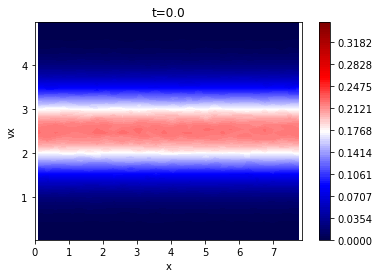

In [7]:
from matplotlib import animation

X, VX = np.meshgrid(bins[0]*Lx, bins[1], indexing='ij')
f_eq  = lambda x, vx : 0.05*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
Nt    = fh_xi1_vx.shape[0] - 1

fig, ax = plt.subplots()

cont = plt.contourf(X, VX, fh_xi1_vx[0]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
#cont = plt.contourf(X, VX, fh_xi1_vx_delta[0]/Lx, np.linspace(-0.04, 0.04, 100), cmap='seismic')
plt.colorbar()
#plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.5)
plt.xlim((0., Lx))

# animation function
def animate(i):
    if i%100 == 0:
        print(i)
    global cont

    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
        
    cont = plt.contourf(X, VX, fh_xi1_vx[i*5]/Lx, np.linspace(0., 0.35, 100), cmap='seismic')
    #cont = plt.contourf(X, VX, fh_xi1_vx_delta[i*5]/Lx, np.linspace(-0.04, 0.04, 100), cmap='seismic')
    #plt.plot(np.linspace(0., Lx, 10), np.ones(10)*vR, 'k--', linewidth=0.5)
    plt.xlim((0., Lx))
    
    plt.xlabel('x')
    plt.ylabel('vx')
    plt.title('t=' + str(tn1[::5][i]))
    
    return cont

anim = animation.FuncAnimation(fig, animate, frames=int(Nt/5) + 1, repeat=False)
anim.save('animation_resonance.mp4', writer=animation.FFMpegWriter())

Text(0, 0.5, 'vx')

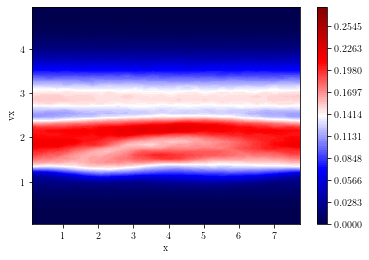

In [134]:
X, VX = np.meshgrid(bins[0]*Lx, bins[1], indexing='ij')
f_eq  = lambda x, vx : 0.05*Ly*Lz/np.sqrt(np.pi)*params.vth*np.exp(-(vx - params.v0x)**2/params.vth**2)
Nt    = fh_xi1_vx.shape[0] - 1

cont = plt.contourf(X, VX, fh_xi1_vx[4500]/Lx, np.linspace(0., 0.28, 100), cmap='seismic')
plt.colorbar()

plt.xlabel('x')
plt.ylabel('vx')

In [7]:
# plot Bz in xy-plane
etaplot = np.linspace(0., 1., 100), np.linspace(0., 1., 100), np.array([0.5])
Bz = np.zeros((3001, 100, 100))

for n in range(3001):
    if n%500==0:
        print(n)
    Bz[n] = tensor_space.evaluate_2form_3d([b1_1[2*n], b2_1[2*n], b3_1[2*n]], etaplot, component=3)[:, :, 0]

0
500
1000
1500
2000
2500
3000


0
100
200
300
400
500
600
700
800
900
1000


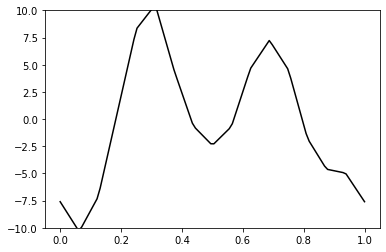

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'k-')

def init():
    ax.set_ylim(-10, 10)
    return ln,

def update(frame):
    ln.set_data(etaplot[0], Bz[frame*3, :, 50])
    if frame%100==0:
        print(frame)
    return ln,

anim = animation.FuncAnimation(fig, update, frames=1001, init_func=init, blit=True)
anim.save('animation_Bz.mp4', writer=animation.FFMpegWriter())

## Particle number scan Cartesian

In [17]:
# import parameters and output data
import simulations.simulation_16062020_1.parameters_16062020_1 as pa
import simulations.simulation_16062020_1.equilibrium_PIC       as eq_PIC
import simulations.simulation_16062020_1.equilibrium_MHD       as eq_MHD

params = pa.parameters()
file1  = h5py.File('simulations/simulation_16062020_1/results_simulation_16062020_1.hdf5', 'r')
file2  = h5py.File('simulations/simulation_16062020_5/results_simulation_16062020_5.hdf5', 'r')
file3  = h5py.File('simulations/simulation_16062020_6/results_simulation_16062020_6.hdf5', 'r')
file4  = h5py.File('simulations/simulation_16062020_7/results_simulation_16062020_7.hdf5', 'r')
file5  = h5py.File('simulations/simulation_16062020_8/results_simulation_16062020_8.hdf5', 'r')
file6  = h5py.File('simulations/simulation_16062020_9/results_simulation_16062020_9.hdf5', 'r')

In [18]:
file7  = h5py.File('simulations/simulation_13072020_1/results_simulation_13072020_1.hdf5', 'r')

In [23]:
en1 = file6['energies/magnetic'][:]
en2 = file7['energies/magnetic'][:]

In [43]:
en1[320]

0.0004217850278860458

In [35]:
en2[3000]

0.15253269829667143

In [32]:
# load perturbed energies, mass and b-coefficients
tn1     = file7['time'][:]
en_U1   = file7['energies/bulk_kinetic'][:]
en_B1   = file7['energies/magnetic'][:]
en_H1   = file7['energies/energetic_deltaf'][:]
en_p1   = file7['energies/bulk_internal'][:]
en_tot1 = en_U1 + en_B1 + en_H1 + en_p1

In [33]:
en_tot1

array([0.01116718, 0.01116718, 0.01116718, ..., 0.0111671 , 0.0111671 ,
       0.0111671 ])

In [3]:
from scipy import integrate

Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

Nel  = params.Nel
bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map     = params.kind_map
params_map   = params.params_map

# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]


# compute equilibrium energies
en_B0   = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0   = eq_PIC.eh_eq(params.kind_map, params.params_map)
en_p0   = 1/(5/3 - 1)*Lx*Ly*Lz

# load perturbed energies, mass and b-coefficients
tn1     = file1['time'][:]
en_U1   = file1['energies/bulk_kinetic'][:]
en_B1   = file1['energies/magnetic'][:]
en_H1   = file1['energies/energetic_deltaf'][:]
en_p1   = file1['energies/bulk_internal'][:]
en_tot1 = en_U1 + en_B1 + en_H1 + en_p1 + en_B0 + en_H0 + en_p0
#mass1   = file1['bulk_mass'][:]
b1_1    = file1['magnetic_field/1_component'][:]
b2_1    = file1['magnetic_field/2_component'][:]
b3_1    = file1['magnetic_field/3_component'][:]


"""
tn2     = file2['time'][:]
en_U2   = file2['energies/bulk_kinetic'][:]
en_B2   = file2['energies/magnetic'][:]
en_H2   = file2['energies/energetic_deltaf'][:]
en_p2   = file2['energies/bulk_internal'][:]
en_tot2 = en_U2 + en_B2 + en_H2 + en_p2 + en_B0 + en_H0 + en_p0
#mass2   = file2['bulk_mass'][:]
b1_2    = file2['magnetic_field/1_component'][:]
b2_2    = file2['magnetic_field/2_component'][:]
b3_2    = file2['magnetic_field/3_component'][:]
"""


tn3     = file3['time'][:]
en_U3   = file3['energies/bulk_kinetic'][:]
en_B3   = file3['energies/magnetic'][:]
en_H3   = file3['energies/energetic_deltaf'][:]
en_p3   = file3['energies/bulk_internal'][:]
en_tot3 = en_U3 + en_B3 + en_H3 + en_p3 + en_B0 + en_H0 + en_p0
#mass3   = file3['bulk_mass'][:]
b1_3    = file3['magnetic_field/1_component'][:]
b2_3    = file3['magnetic_field/2_component'][:]
b3_3    = file3['magnetic_field/3_component'][:]



tn4     = file4['time'][:]
en_U4   = file4['energies/bulk_kinetic'][:]
en_B4   = file4['energies/magnetic'][:]
en_H4   = file4['energies/energetic_deltaf'][:]
en_p4   = file4['energies/bulk_internal'][:]
en_tot4 = en_U4 + en_B4 + en_H4 + en_p4 + en_B0 + en_H0 + en_p0
#mass4   = file4['bulk_mass'][:]
b1_4    = file4['magnetic_field/1_component'][:]
b2_4    = file4['magnetic_field/2_component'][:]
b3_4    = file4['magnetic_field/3_component'][:]


tn5     = file5['time'][:]
en_U5   = file5['energies/bulk_kinetic'][:]
en_B5   = file5['energies/magnetic'][:]
en_H5   = file5['energies/energetic_deltaf'][:]
en_p5   = file5['energies/bulk_internal'][:]
en_tot5 = en_U5 + en_B5 + en_H5 + en_p5 + en_B0 + en_H0 + en_p0
#mass4   = file4['bulk_mass'][:]
b1_5    = file5['magnetic_field/1_component'][:]
b2_5    = file5['magnetic_field/2_component'][:]
b3_5    = file5['magnetic_field/3_component'][:]


tn6     = file6['time'][:]
en_U6   = file6['energies/bulk_kinetic'][:]
en_B6   = file6['energies/magnetic'][:]
en_H6   = file6['energies/energetic_deltaf'][:]
en_p6   = file6['energies/bulk_internal'][:]
en_tot6 = en_U6 + en_B6 + en_H6 + en_p6 + en_B0 + en_H0 + en_p0
#mass4   = file4['bulk_mass'][:]
b1_6    = file6['magnetic_field/1_component'][:]
b2_6    = file6['magnetic_field/2_component'][:]
b3_6    = file6['magnetic_field/3_component'][:]


# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.8, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=0.8 + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.8

In [4]:
# evaluate Jacobian determinant
det_DF_grev = np.empty((len(greville[0]), len(greville[1]), len(greville[2])), dtype=float, order='F')

for i1 in range(greville[0].size):
    for i2 in range(greville[1].size):
        for i3 in range(greville[2].size):

            det_DF_grev[i1, i2, i3] = mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)

In [5]:
# determine L-infinity norm of div(B)
er_div1 = np.zeros(tn1.size)
#er_div2 = np.zeros(tn2.size)
er_div3 = np.zeros(tn3.size)
er_div4 = np.zeros(tn4.size)
er_div5 = np.zeros(tn5.size)
er_div6 = np.zeros(tn6.size)

for tn in range(tn1.size):
    b_div       = div.dot(np.concatenate((b1_1[tn].flatten(), b2_1[tn].flatten(), b3_1[tn].flatten())))
    er_div1[tn] = (np.abs(tensor_space.evaluate_3form_3d(b_div, greville))/det_DF_grev).max()
    
#for tn in range(tn2.size):
 #   b_div       = div.dot(np.concatenate((b1_2[tn].flatten(), b2_2[tn].flatten(), b3_2[tn].flatten())))
  #  er_div2[tn] = (np.abs(tensor_space.evaluate_3form_3d(b_div, greville))/det_DF_grev).max()
    
for tn in range(tn3.size):
    b_div       = div.dot(np.concatenate((b1_3[tn].flatten(), b2_3[tn].flatten(), b3_3[tn].flatten())))
    er_div3[tn] = (np.abs(tensor_space.evaluate_3form_3d(b_div, greville))/det_DF_grev).max()
    
for tn in range(tn4.size):
    b_div       = div.dot(np.concatenate((b1_4[tn].flatten(), b2_4[tn].flatten(), b3_4[tn].flatten())))
    er_div4[tn] = (np.abs(tensor_space.evaluate_3form_3d(b_div, greville))/det_DF_grev).max()
    
for tn in range(tn5.size):
    b_div       = div.dot(np.concatenate((b1_5[tn].flatten(), b2_5[tn].flatten(), b3_5[tn].flatten())))
    er_div5[tn] = (np.abs(tensor_space.evaluate_3form_3d(b_div, greville))/det_DF_grev).max()
    
for tn in range(tn6.size):
    b_div       = div.dot(np.concatenate((b1_6[tn].flatten(), b2_6[tn].flatten(), b3_6[tn].flatten())))
    er_div6[tn] = (np.abs(tensor_space.evaluate_3form_3d(b_div, greville))/det_DF_grev).max()

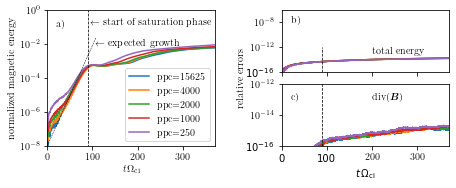

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex='col')

fig.set_figheight(2.5)
fig.set_figwidth(7.2)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

gs = axs[0, 0].get_gridspec()

# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0:, 0])

axbig.semilogy(tn1, en_B1/en_tot1[0], label='ppc=15625')
#axbig.semilogy(tn2, en_B2/en_tot2[0], label='ppc=7800')
axbig.semilogy(tn3, en_B3/en_tot3[0], label='ppc=4000')
axbig.semilogy(tn4, en_B4/en_tot4[0], label='ppc=2000')
axbig.semilogy(tn5, en_B5/en_tot5[0], label='ppc=1000')
axbig.semilogy(tn6, en_B6/en_tot6[0], label='ppc=250')
axbig.semilogy(tn1[0:2150], 1e-8*np.exp(2*tn1[0:2150]*wi), 'k--', linewidth=0.5)

axbig.set_ylim((1e-8, 1e0))
axbig.set_xlim((0., 370.))
axbig.set_xlabel('$t\Omega_\mathrm{ci}$')
axbig.set_ylabel('normalized magnetic energy')
axbig.legend()
axbig.plot(np.ones(10)*90, np.linspace(1e-9, 1e0, 10), 'k--', linewidth=0.75)
axbig.text(95, 1.5e-1, '$\leftarrow$ start of saturation phase')
axbig.text(105, 8e-3, '$\leftarrow$ expected growth')
axbig.text(20, 1e-1, 'a)')


axs[0, 1].semilogy(tn1, np.abs(en_tot1[0] - en_tot1)/en_tot1[0])
#axs[0, 1].semilogy(tn2, np.abs(en_tot2[0] - en_tot2)/en_tot2[0])
axs[0, 1].semilogy(tn3, np.abs(en_tot3[0] - en_tot3)/en_tot3[0])
axs[0, 1].semilogy(tn4, np.abs(en_tot4[0] - en_tot4)/en_tot4[0])
axs[0, 1].semilogy(tn5, np.abs(en_tot5[0] - en_tot5)/en_tot5[0])
axs[0, 1].semilogy(tn6, np.abs(en_tot6[0] - en_tot6)/en_tot6[0])
axs[0, 1].set_ylim((1e-16, 1e-6))
axs[0, 1].set_xlim((0., 370.))
axs[0, 1].text(20, 1e-8, 'b)')
axs[0, 1].plot(np.ones(10)*90, np.linspace(1e-16, 1e-12, 10), 'k--', linewidth=0.75)
axs[0, 1].text(200, 1e-13, 'total energy')


axs[1, 1].semilogy(tn1, er_div1)
#plt.semilogy(tn2, er_div2)
axs[1, 1].semilogy(tn3, er_div3)
axs[1, 1].semilogy(tn4, er_div4)
axs[1, 1].semilogy(tn5, er_div5)
axs[1, 1].semilogy(tn6, er_div6)

axs[1, 1].set_xlabel(r'$t\,\Omega_\mathrm{ci}$')
axs[1, 1].set_ylim((1e-16, 1e-12))
axs[1, 1].text(20, 1e-13, 'c)')
axs[1, 1].plot(np.ones(10)*90, np.linspace(1e-16, 1e-12, 10), 'k--', linewidth=0.75)
axs[1, 1].text(200, 1e-13, r'$\mathrm{div}(\boldsymbol{B})$')

fig.text(0.5, 0.5, 'relative errors', ha='center', va='center', rotation='vertical')


plt.subplots_adjust(wspace=0.4, hspace=0.2)

## Particle scan including non-Hamiltonian terms

In [2]:
# import parameters and output data
import simulations.simulation_19062020_1.parameters_19062020_1 as pa
import simulations.simulation_19062020_1.equilibrium_PIC       as eq_PIC
import simulations.simulation_19062020_1.equilibrium_MHD       as eq_MHD

params = pa.parameters()
file1  = h5py.File('../../simulations/simulation_19062020_1/results_simulation_19062020_1.hdf5', 'r')
file2  = h5py.File('../../simulations/simulation_19062020_2/results_simulation_19062020_2.hdf5', 'r')
file3  = h5py.File('../../simulations/simulation_19062020_3/results_simulation_19062020_3.hdf5', 'r')
file4  = h5py.File('../../simulations/simulation_19062020_4/results_simulation_19062020_4.hdf5', 'r')
file5  = h5py.File('../../simulations/simulation_19062020_5/results_simulation_19062020_5.hdf5', 'r')

In [3]:
from scipy import integrate

Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[3]

Nel  = params.Nel
bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map    = params.kind_map
params_map  = params.params_map

# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]


# compute equilibrium energies
en_B0   = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0   = eq_PIC.eh_eq(params.kind_map, params.params_map)
en_p0   = 1/(5/3 - 1)*Lx*Ly*Lz

# load perturbed energies, mass and b-coefficients
tn1     = file1['time'][:]
en_U1   = file1['energies/bulk_kinetic'][:]
en_B1   = file1['energies/magnetic'][:]
en_H1   = file1['energies/energetic_deltaf'][:]
en_p1   = file1['energies/bulk_internal'][:]
en_tot1 = en_U1 + en_B1 + en_H1 + en_p1 + en_B0 + en_H0 + en_p0
mass1   = file1['bulk_mass'][:]
b1_1    = file1['magnetic_field/1_component'][:]
b2_1    = file1['magnetic_field/2_component'][:]
b3_1    = file1['magnetic_field/3_component'][:]

tn2     = file2['time'][:]
en_U2   = file2['energies/bulk_kinetic'][:]
en_B2   = file2['energies/magnetic'][:]
en_H2   = file2['energies/energetic_deltaf'][:]
en_p2   = file2['energies/bulk_internal'][:]
en_tot2 = en_U2 + en_B2 + en_H2 + en_p2 + en_B0 + en_H0 + en_p0
mass2   = file2['bulk_mass'][:]
b1_2    = file2['magnetic_field/1_component'][:]
b2_2    = file2['magnetic_field/2_component'][:]
b3_2    = file2['magnetic_field/3_component'][:]

tn3     = file3['time'][:]
en_U3   = file3['energies/bulk_kinetic'][:]
en_B3   = file3['energies/magnetic'][:]
en_H3   = file3['energies/energetic_deltaf'][:]
en_p3   = file3['energies/bulk_internal'][:]
en_tot3 = en_U3 + en_B3 + en_H3 + en_p3 + en_B0 + en_H0 + en_p0
mass3   = file3['bulk_mass'][:]
b1_3    = file3['magnetic_field/1_component'][:]
b2_3    = file3['magnetic_field/2_component'][:]
b3_3    = file3['magnetic_field/3_component'][:]

tn4     = file4['time'][:]
en_U4   = file4['energies/bulk_kinetic'][:]
en_B4   = file4['energies/magnetic'][:]
en_H4   = file4['energies/energetic_deltaf'][:]
en_p4   = file4['energies/bulk_internal'][:]
en_tot4 = en_U4 + en_B4 + en_H4 + en_p4 + en_B0 + en_H0 + en_p0
mass4   = file4['bulk_mass'][:]
b1_4    = file4['magnetic_field/1_component'][:]
b2_4    = file4['magnetic_field/2_component'][:]
b3_4    = file4['magnetic_field/3_component'][:]


tn5     = file5['time'][:]
en_U5   = file5['energies/bulk_kinetic'][:]
en_B5   = file5['energies/magnetic'][:]
en_H5   = file5['energies/energetic_deltaf'][:]
en_p5   = file5['energies/bulk_internal'][:]
en_tot5 = en_U5 + en_B5 + en_H5 + en_p5 + en_B0 + en_H0 + en_p0
mass5   = file5['bulk_mass'][:]
b1_5    = file5['magnetic_field/1_component'][:]
b2_5    = file5['magnetic_field/2_component'][:]
b3_5    = file5['magnetic_field/3_component'][:]


# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.8, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=0.8 + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.8

In [4]:
# determine L-infinity norm of div(B)
er_div1 = np.zeros(tn1.size, dtype=float)
er_div2 = np.zeros(tn2.size, dtype=float)
er_div3 = np.zeros(tn3.size, dtype=float)
er_div4 = np.zeros(tn4.size, dtype=float)
er_div5 = np.zeros(tn5.size, dtype=float)

b_div_grev = np.empty((greville[0].size, greville[1].size, greville[2].size), dtype=float)

for tn in range(tn1.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_1[tn].flatten(), b2_1[tn].flatten(), b3_1[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
    
    er_div1[tn] = np.abs(b_div_grev).max()
print('1 done')   

    
for tn in range(tn2.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_2[tn].flatten(), b2_2[tn].flatten(), b3_2[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)

    er_div2[tn] = np.abs(b_div_grev).max()
print('2 done')  

for tn in range(tn3.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_3[tn].flatten(), b2_3[tn].flatten(), b3_3[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
    
    er_div3[tn] = np.abs(b_div_grev).max()
print('3 done')  
    
for tn in range(tn4.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_4[tn].flatten(), b2_4[tn].flatten(), b3_4[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
                
    er_div4[tn] = np.abs(b_div_grev).max()
print('4 done')

for tn in range(tn5.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_5[tn].flatten(), b2_5[tn].flatten(), b3_5[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map, params_map)
                
    er_div5[tn] = np.abs(b_div_grev).max()
print('5 done')  

1 done
2 done
3 done
4 done
5 done


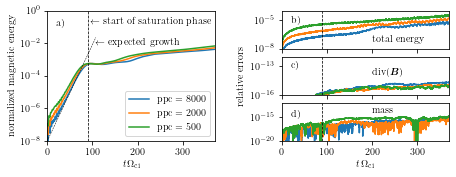

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=3, sharex='col')

fig.set_figheight(2.4)
fig.set_figwidth(7.2)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

gs = axs[0, 0].get_gridspec()

# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0:, 0])

# left plot: magnetic energy
axbig.semilogy(tn1, en_B1/en_tot1[0], label='$\mathrm{ppc}=8000$')
#axbig.semilogy(tn2, en_B2/en_tot2[0], label='$\mathrm{ppc}=4000$')
axbig.semilogy(tn3, en_B3/en_tot3[0], label='$\mathrm{ppc}=2000$')
#axbig.semilogy(tn4, en_B4/en_tot4[0], label='$\mathrm{ppc}=1000$')
axbig.semilogy(tn5, en_B5/en_tot5[0], label='$\mathrm{ppc}=500$')
axbig.semilogy(tn1[0:2150], 1e-8*np.exp(2*tn1[0:2150]*wi), 'k--', linewidth=0.5)

axbig.set_ylim((1e-8, 1e0))
axbig.set_xlim((0., 370.))
axbig.set_xlabel('$t\Omega_\mathrm{ci}$')
axbig.set_ylabel('normalized magnetic energy')
axbig.legend()
axbig.plot(np.ones(10)*90, np.linspace(1e-9, 1e0, 10), 'k--', linewidth=0.75)
axbig.text(95, 1.5e-1, '$\leftarrow$ start of saturation phase')
axbig.text(105, 8e-3, '$\leftarrow$ expected growth')
axbig.text(20, 1e-1, 'a)')


# right plot 1: total energy
axs[0, 1].semilogy(tn1, np.abs(en_tot1[0] - en_tot1)/en_tot1[0])
#axs[0, 1].semilogy(tn2, np.abs(en_tot2[0] - en_tot2)/en_tot2[0])
axs[0, 1].semilogy(tn3, np.abs(en_tot3[0] - en_tot3)/en_tot3[0])
#axs[0, 1].semilogy(tn4, np.abs(en_tot4[0] - en_tot4)/en_tot4[0])
axs[0, 1].semilogy(tn5, np.abs(en_tot5[0] - en_tot5)/en_tot5[0])
axs[0, 1].set_ylim((1e-8, 1e-4))
axs[0, 1].set_xlim((0., 370.))
axs[0, 1].text(20, 5e-6, 'b)')
axs[0, 1].plot(np.ones(10)*90, np.linspace(1e-8, 1e-4, 10), 'k--', linewidth=0.75)
axs[0, 1].text(200, 5e-8, 'total energy')


# right plot 2: div(B)
axs[1, 1].semilogy(tn1, er_div1)
#axs[1, 1].semilogy(tn2, er_div2)
axs[1, 1].semilogy(tn3, er_div3)
#axs[1, 1].semilogy(tn4, er_div4)
axs[1, 1].semilogy(tn5, er_div5)
axs[1, 1].set_ylim((1e-16, 1e-12))
axs[1, 1].set_xlim((0., 370.))
axs[1, 1].text(20, 6e-14, 'c)')
axs[1, 1].plot(np.ones(10)*90, np.linspace(1e-16, 1e-12, 10), 'k--', linewidth=0.75)
axs[1, 1].text(200, 1e-14, r'$\mathrm{div}(\boldsymbol{B})$')


# right plot 3: bulk mass
axs[2, 1].semilogy(tn1, np.abs(mass1))
#axs[2, 1].semilogy(tn2, np.abs(mass2))
axs[2, 1].semilogy(tn3, np.abs(mass3))
#axs[2, 1].semilogy(tn4, np.abs(mass4))
axs[2, 1].semilogy(tn5, np.abs(mass5))
axs[2, 1].set_ylim((1e-20, 1e-12))
axs[2, 1].set_xlim((0., 370.))
axs[2, 1].plot(np.ones(10)*90, np.linspace(1e-20, 1e-12, 10), 'k--', linewidth=0.75)
axs[2, 1].set_xlabel(r'$t\,\Omega_\mathrm{ci}$')
axs[2, 1].text(200, 5e-15, 'mass')
axs[2, 1].text(20, 1e-15, 'd)')

fig.text(0.5, 0.5, 'relative errors', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.savefig('paper_draft_07_2020/wave_particle_nonHamiltonian.pdf', bbox_inches = 'tight')

## Mesh and metric

In [5]:
# import parameters and output data
import simulations.simulation_20062020_1.parameters_20062020_1 as pa
import simulations.simulation_20062020_1.equilibrium_PIC       as eq_PIC
import simulations.simulation_20062020_1.equilibrium_MHD       as eq_MHD

params = pa.parameters()
file1  = h5py.File('../../simulations/simulation_20062020_1/results_simulation_20062020_1.hdf5', 'r')
file2  = h5py.File('../../simulations/simulation_20062020_2/results_simulation_20062020_2.hdf5', 'r')

In [6]:
from scipy import integrate

Lx = params.params_map[0]
Ly = params.params_map[1]
Lz = params.params_map[2]

Nel  = params.Nel

bc   = params.bc
p    = params.p

nq_el = params.nq_el
nq_pr = params.nq_pr

kind_map1    = 1
kind_map2    = 3

params_map1  = [Lx, Ly, Lz]
params_map2  = [Lx, Ly, 0.05, Lz]


# create tensor-product space
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                                    # 3d tensor product space

# dicrete divergence
derivatives = der.discrete_derivatives(tensor_space)
div         = derivatives.div_3d()

# greville points
greville    = [bsp.greville(T, p, bc) for T, p, bc in zip(T, p, bc)]

# compute equilibrium energies
en_B0   = integrate.nquad(eq_MHD.bx_eq, [[0., Lx], [0., Ly], [0., Lz]])[0]/2
en_H0   = eq_PIC.eh_eq(params.kind_map, params.params_map)
en_p0   = 1/(5/3 - 1)*Lx*Ly*Lz

# load perturbed energies, mass and b-coefficients
tn1     = file1['time'][:]
en_U1   = file1['energies/bulk_kinetic'][:]
en_B1   = file1['energies/magnetic'][:]
en_H1   = file1['energies/energetic_deltaf'][:]
en_p1   = file1['energies/bulk_internal'][:]
en_tot1 = en_U1 + en_B1 + en_H1 + en_p1 + en_B0 + en_H0 + en_p0
mass1   = file1['bulk_mass'][:]
b1_1    = file1['magnetic_field/1_component'][:]
b2_1    = file1['magnetic_field/2_component'][:]
b3_1    = file1['magnetic_field/3_component'][:]

tn2     = file2['time'][:]
en_U2   = file2['energies/bulk_kinetic'][:]
en_B2   = file2['energies/magnetic'][:]
en_H2   = file2['energies/energetic_deltaf'][:]
en_p2   = file2['energies/bulk_internal'][:]
en_tot2 = en_U2 + en_B2 + en_H2 + en_p2 + en_B0 + en_H0 + en_p0
mass2   = file2['bulk_mass'][:]
b1_2    = file2['magnetic_field/1_component'][:]
b2_2    = file2['magnetic_field/2_component'][:]
b3_2    = file2['magnetic_field/3_component'][:]


# solve dispersion relation
w, counter = disp.solveDispersionFullOrbit(k=0.8, pol=+1, wch=+1, vA=1., vth=1., v0=2.5, nuh=0.05, Ah=1., Zh=1., AMHD=1., initial_guess=0.8 + 0j, tol=1e-10, max_it=100)
wi = np.imag(w)
wr = np.real(w)

# resonant velocity
vR = (wr + 1.)/0.8

In [7]:
# determine L-infinity norm of div(B)
er_div1 = np.zeros(tn1.size, dtype=float)
er_div2 = np.zeros(tn2.size, dtype=float)

b_div_grev = np.empty((greville[0].size, greville[1].size, greville[2].size), dtype=float)

for tn in range(tn1.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_1[tn].flatten(), b2_1[tn].flatten(), b3_1[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map1, params_map1)
    
    er_div1[tn] = np.abs(b_div_grev).max()
print('1 done')   

    
for tn in range(tn2.size):
    
    # compute coefficients in V3
    b_div       = div.dot(np.concatenate((b1_2[tn].flatten(), b2_2[tn].flatten(), b3_2[tn].flatten())))
    
    # evaluate at greville points
    for i1 in range(greville[0].size):
        for i2 in range(greville[1].size):
            for i3 in range(greville[2].size):
                b_div_grev[i1, i2, i3] = tensor_space.evaluate_DDD(greville[0][i1], greville[1][i2], greville[2][i3], b_div)/mapping.det_df(greville[0][i1], greville[1][i2], greville[2][i3], kind_map2, params_map2)

    er_div2[tn] = np.abs(b_div_grev).max()
print('2 done')

1 done
2 done


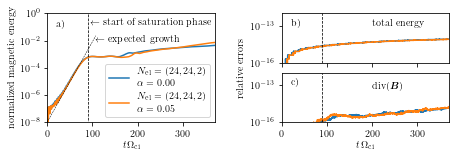

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex='col')

fig.set_figheight(2.0)
fig.set_figwidth(7.2)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

gs = axs[0, 0].get_gridspec()

# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0:, 0])

# left plot: magnetic energy
axbig.semilogy(tn1, en_B1/en_tot1[0], label=r'$N_\mathrm{el}=(24,24,2)$' + '\n' + r'$\alpha=0.00$')
axbig.semilogy(tn2, en_B2/en_tot2[0], label=r'$N_\mathrm{el}=(24,24,2)$' + '\n' + r'$\alpha=0.05$')
axbig.semilogy(tn1[0:1075], 1e-8*np.exp(2*tn1[0:1075]*wi), 'k--', linewidth=0.5)
axbig.set_ylim((1e-8, 1e0))
axbig.set_xlim((0., 370.))
axbig.set_xlabel('$t\Omega_\mathrm{ci}$')
axbig.set_ylabel('normalized magnetic energy')
axbig.legend()
axbig.plot(np.ones(10)*90, np.linspace(1e-9, 1e0, 10), 'k--', linewidth=0.75)
axbig.text(95, 1.5e-1, '$\leftarrow$ start of saturation phase')
axbig.text(105, 8e-3, '$\leftarrow$ expected growth')
axbig.text(20, 1e-1, 'a)')


axs[0, 1].semilogy(tn1, np.abs(en_tot1[0] - en_tot1)/en_tot1[0])
axs[0, 1].semilogy(tn2, np.abs(en_tot2[0] - en_tot2)/en_tot2[0])
axs[0, 1].set_ylim((1e-16, 1e-12))
axs[0, 1].set_xlim((0., 370.))
axs[0, 1].text(20, 1e-13, 'b)')
axs[0, 1].plot(np.ones(10)*90, np.linspace(1e-16, 1e-12, 10), 'k--', linewidth=0.75)
axs[0, 1].text(200, 1e-13, 'total energy')



axs[1, 1].semilogy(tn1, er_div1)
axs[1, 1].semilogy(tn2, er_div2)
axs[1, 1].set_xlabel(r'$t\,\Omega_\mathrm{ci}$')
axs[1, 1].set_ylim((1e-16, 1e-12))
axs[1, 1].text(20, 1e-13, 'c)')
axs[1, 1].plot(np.ones(10)*90, np.linspace(1e-16, 1e-12, 10), 'k--', linewidth=0.75)
axs[1, 1].text(200, 5e-14, r'$\mathrm{div}(\boldsymbol{B})$')

fig.text(0.5, 0.5, 'relative errors', ha='center', va='center', rotation='vertical')


plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.savefig('paper_draft_07_2020/wave_particle_mesh_metric.pdf', bbox_inches = 'tight')

## OpenMp scaling

In [3]:
# import output data
file1  = h5py.File('simulations/simulation_18062020_1/results_simulation_18062020_1.hdf5', 'r')
file2  = h5py.File('simulations/simulation_18062020_2/results_simulation_18062020_2.hdf5', 'r')
file3  = h5py.File('simulations/simulation_18062020_3/results_simulation_18062020_3.hdf5', 'r')
file4  = h5py.File('simulations/simulation_18062020_4/results_simulation_18062020_4.hdf5', 'r')
file5  = h5py.File('simulations/simulation_18062020_5/results_simulation_18062020_5.hdf5', 'r')


file6  = h5py.File('simulations/simulation_18062020_6/results_simulation_18062020_6.hdf5', 'r')
file7  = h5py.File('simulations/simulation_18062020_7/results_simulation_18062020_7.hdf5', 'r')
file8  = h5py.File('simulations/simulation_18062020_8/results_simulation_18062020_8.hdf5', 'r')
file9  = h5py.File('simulations/simulation_18062020_9/results_simulation_18062020_9.hdf5', 'r')
file10 = h5py.File('simulations/simulation_18062020_10/results_simulation_18062020_10.hdf5', 'r')

In [4]:
# get elapsed times
times_car = np.zeros((5, 7))
times_col = np.zeros((5, 7))

# accumulation step 1
times_car[0, 0] = sum(file1['times_elapsed/accumulation_step1'][1:])/100
times_car[1, 0] = sum(file2['times_elapsed/accumulation_step1'][1:])/100
times_car[2, 0] = sum(file3['times_elapsed/accumulation_step1'][1:])/100
times_car[3, 0] = sum(file4['times_elapsed/accumulation_step1'][1:])/100
times_car[4, 0] = sum(file5['times_elapsed/accumulation_step1'][1:])/100

times_col[0, 0] = sum(file6['times_elapsed/accumulation_step1'][1:])/100
times_col[1, 0] = sum(file7['times_elapsed/accumulation_step1'][1:])/100
times_col[2, 0] = sum(file8['times_elapsed/accumulation_step1'][1:])/100
times_col[3, 0] = sum(file9['times_elapsed/accumulation_step1'][1:])/100
times_col[4, 0] = sum(file10['times_elapsed/accumulation_step1'][1:])/100

# accumulation step 3
times_car[0, 1] = sum(file1['times_elapsed/accumulation_step3'][1:])/100
times_car[1, 1] = sum(file2['times_elapsed/accumulation_step3'][1:])/100
times_car[2, 1] = sum(file3['times_elapsed/accumulation_step3'][1:])/100
times_car[3, 1] = sum(file4['times_elapsed/accumulation_step3'][1:])/100
times_car[4, 1] = sum(file5['times_elapsed/accumulation_step3'][1:])/100

times_col[0, 1] = sum(file6['times_elapsed/accumulation_step3'][1:])/100
times_col[1, 1] = sum(file7['times_elapsed/accumulation_step3'][1:])/100
times_col[2, 1] = sum(file8['times_elapsed/accumulation_step3'][1:])/100
times_col[3, 1] = sum(file9['times_elapsed/accumulation_step3'][1:])/100
times_col[4, 1] = sum(file10['times_elapsed/accumulation_step3'][1:])/100


# evaluation_1form
times_car[0, 2] = sum(file1['times_elapsed/evaluation_1form'][1:])/100
times_car[1, 2] = sum(file2['times_elapsed/evaluation_1form'][1:])/100
times_car[2, 2] = sum(file3['times_elapsed/evaluation_1form'][1:])/100
times_car[3, 2] = sum(file4['times_elapsed/evaluation_1form'][1:])/100
times_car[4, 2] = sum(file5['times_elapsed/evaluation_1form'][1:])/100

times_col[0, 2] = sum(file6['times_elapsed/evaluation_1form'][1:])/100
times_col[1, 2] = sum(file7['times_elapsed/evaluation_1form'][1:])/100
times_col[2, 2] = sum(file8['times_elapsed/evaluation_1form'][1:])/100
times_col[3, 2] = sum(file9['times_elapsed/evaluation_1form'][1:])/100
times_col[4, 2] = sum(file10['times_elapsed/evaluation_1form'][1:])/100


# evaluation_2form
times_car[0, 3] = sum(file1['times_elapsed/evaluation_2form'][1:])/100
times_car[1, 3] = sum(file2['times_elapsed/evaluation_2form'][1:])/100
times_car[2, 3] = sum(file3['times_elapsed/evaluation_2form'][1:])/100
times_car[3, 3] = sum(file4['times_elapsed/evaluation_2form'][1:])/100
times_car[4, 3] = sum(file5['times_elapsed/evaluation_2form'][1:])/100

times_col[0, 3] = sum(file6['times_elapsed/evaluation_2form'][1:])/100
times_col[1, 3] = sum(file7['times_elapsed/evaluation_2form'][1:])/100
times_col[2, 3] = sum(file8['times_elapsed/evaluation_2form'][1:])/100
times_col[3, 3] = sum(file9['times_elapsed/evaluation_2form'][1:])/100
times_col[4, 3] = sum(file10['times_elapsed/evaluation_2form'][1:])/100

# pusher_step3
times_car[0, 4] = sum(file1['times_elapsed/pusher_step3'][1:])/100
times_car[1, 4] = sum(file2['times_elapsed/pusher_step3'][1:])/100
times_car[2, 4] = sum(file3['times_elapsed/pusher_step3'][1:])/100
times_car[3, 4] = sum(file4['times_elapsed/pusher_step3'][1:])/100
times_car[4, 4] = sum(file5['times_elapsed/pusher_step3'][1:])/100

times_col[0, 4] = sum(file6['times_elapsed/pusher_step3'][1:])/100
times_col[1, 4] = sum(file7['times_elapsed/pusher_step3'][1:])/100
times_col[2, 4] = sum(file8['times_elapsed/pusher_step3'][1:])/100
times_col[3, 4] = sum(file9['times_elapsed/pusher_step3'][1:])/100
times_col[4, 4] = sum(file10['times_elapsed/pusher_step3'][1:])/100

# pusher_step4
times_car[0, 5] = sum(file1['times_elapsed/pusher_step4'][1:])/100
times_car[1, 5] = sum(file2['times_elapsed/pusher_step4'][1:])/100
times_car[2, 5] = sum(file3['times_elapsed/pusher_step4'][1:])/100
times_car[3, 5] = sum(file4['times_elapsed/pusher_step4'][1:])/100
times_car[4, 5] = sum(file5['times_elapsed/pusher_step4'][1:])/100

times_col[0, 5] = sum(file6['times_elapsed/pusher_step4'][1:])/100
times_col[1, 5] = sum(file7['times_elapsed/pusher_step4'][1:])/100
times_col[2, 5] = sum(file8['times_elapsed/pusher_step4'][1:])/100
times_col[3, 5] = sum(file9['times_elapsed/pusher_step4'][1:])/100
times_col[4, 5] = sum(file10['times_elapsed/pusher_step4'][1:])/100

# pusher_step5
times_car[0, 6] = sum(file1['times_elapsed/pusher_step5'][1:])/100
times_car[1, 6] = sum(file2['times_elapsed/pusher_step5'][1:])/100
times_car[2, 6] = sum(file3['times_elapsed/pusher_step5'][1:])/100
times_car[3, 6] = sum(file4['times_elapsed/pusher_step5'][1:])/100
times_car[4, 6] = sum(file5['times_elapsed/pusher_step5'][1:])/100

times_col[0, 6] = sum(file6['times_elapsed/pusher_step5'][1:])/100
times_col[1, 6] = sum(file7['times_elapsed/pusher_step5'][1:])/100
times_col[2, 6] = sum(file8['times_elapsed/pusher_step5'][1:])/100
times_col[3, 6] = sum(file9['times_elapsed/pusher_step5'][1:])/100
times_col[4, 6] = sum(file10['times_elapsed/pusher_step5'][1:])/100

In [5]:
num_threads = np.array([1, 2, 4, 8, 16])

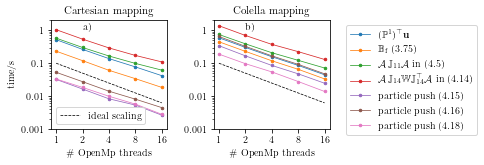

In [12]:
fig = plt.figure()
fig.set_figheight(2.)
fig.set_figwidth(5)


plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}",r"\usepackage{amssymb}"]


# Cartesian
ax1 = plt.subplot(1, 2, 1)
plt.plot(num_threads, times_car[:, 2], 'o-', markersize=2.5, linewidth=0.75)
plt.plot(num_threads, times_car[:, 3], 'o-', markersize=2.5, linewidth=0.75)
plt.plot(num_threads, times_car[:, 0], 'o-', markersize=2.5, linewidth=0.75)
plt.plot(num_threads, times_car[:, 1], 'o-', markersize=2.5, linewidth=0.75)
plt.plot(num_threads, times_car[:, 4], 'o-', markersize=2.5, linewidth=0.75)
plt.plot(num_threads, times_car[:, 5], 'o-', markersize=2.5, linewidth=0.75)
plt.plot(num_threads, times_car[:, 6], 'o-', markersize=2.5, linewidth=0.75)
plt.plot(num_threads, 1e-1*1/num_threads, 'k--', linewidth=0.75, label='ideal scaling')
plt.yscale('log')
plt.xscale('log', basex=2)
plt.xlabel('$\#$ OpenMp threads')
plt.ylabel('time/s')
plt.title('Cartesian mapping', fontsize=11)
plt.ylim((1e-3, 2e0))
plt.legend(loc='lower left')
plt.text(2, 1, 'a)')
plt.xticks([1, 2, 4, 8, 16], ['1', '2', '4', '8', '16'])
plt.yticks([0.001, 0.01, 0.1, 1], ['0.001', '0.01', '0.1', '1'])



# Colella
ax2  = plt.subplot(1, 2, 2)
plt.plot(num_threads, times_col[:, 2], 'o-', markersize=2.5, linewidth=0.75, label=r'$(\mathbb{P}^1)^\top\mathbf{u}$')
plt.plot(num_threads, times_col[:, 3], 'o-', markersize=2.5, linewidth=0.75, label=r'$\mathbb{B}_{\mathrm{f}}$ (3.75)')
plt.plot(num_threads, times_col[:, 0], 'o-', markersize=2.5, linewidth=0.75, label=r'$\mathcal{A}\,\mathbb{J}_{11}\mathcal{A}$ in (4.5)')
plt.plot(num_threads, times_col[:, 1], 'o-', markersize=2.5, linewidth=0.75, label=r'$\mathcal{A}\,\mathbb{J}_{14}\mathbb{W}\mathbb{J}_{14}^\top\mathcal{A}$ in (4.14)')
plt.plot(num_threads, times_col[:, 4], 'o-', markersize=2.5, linewidth=0.75, label='particle push (4.15)')
plt.plot(num_threads, times_col[:, 5], 'o-', markersize=2.5, linewidth=0.75, label='particle push (4.16)')
plt.plot(num_threads, times_col[:, 6], 'o-', markersize=2.5, linewidth=0.75, label='particle push (4.18)')
plt.plot(num_threads, 1e-1*1/num_threads, 'k--', linewidth=0.75)
plt.yscale('log')
plt.xscale('log', basex=2)
plt.xlabel('$\#$ OpenMp threads')
#plt.ylabel('time/s')
plt.title('Colella mapping', fontsize=11)
plt.ylim((1e-3, 2e0))
plt.text(2, 1, 'b)')
plt.xticks([1, 2, 4, 8, 16], ['1', '2', '4', '8', '16'])
plt.yticks([0.001, 0.01, 0.1, 1], ['0.001', '0.01', '0.1', '1'])
plt.legend(bbox_to_anchor=(1.1, 1.0, 0., 0.))
#plt.yticks([])

plt.subplots_adjust(wspace=0.4)
plt.savefig('papers/02_FEEC_MHD/draft_June2020/scaling.pdf', bbox_inches = 'tight')